# Group Name: Pi
    
 Participants: Graham Bachman, Keith Hancock, Mallory Cotton-Witehorn, Sam Dean, Wei Qi
    
 Topic: Creating and Using a Neural Network to Predict AirBnB Prices in San Francisco, CA



Dataset comes from [http://insideairbnb.com/get-the-data.html], and for this project we looked at San Francisco, CA specifically. 

# Pre-Processing and Exploratory Analysis

In [1]:
# Importing required libraries
## Had to spend about an hour looking up how to install xgboost, kera (Mac OS Struggles)
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1000)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
#from keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/keithhancock2/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
raw_df = pd.read_csv('listings.csv')
print(f"the dataset contatins {len(raw_df)} AirBnb Listings")
print(raw_df.shape)
pd.set_option('display.max_rows', None)

the dataset contatins 8572 AirBnb Listings
(8572, 106)


/Users/keithhancock2/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Dropping initial columns

Dropping free-text columns because natural language processing is not relevant at this moment, and other columns not useful for price analysis (like host name, property name, etc.)

In [3]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)
print(df.shape)
print(df.head(10))

(8572, 79)
      id experiences_offered host_since  host_response_time  \
0    958                none    7/31/08      within an hour   
1   5858                none     3/2/09        within a day   
2   7918                none    6/17/09      within an hour   
3   8142                none    6/17/09      within an hour   
4   8339                none     7/2/09        within a day   
5   8739                none    1/27/09      within an hour   
6   9225                none     8/4/09      within an hour   
7  10251                none    8/31/09        within a day   
8  10578                none     9/8/09        within a day   
9  10820                none    9/15/09  within a few hours   

  host_response_rate host_acceptance_rate host_is_superhost  \
0               100%                  99%                 t   
1               100%                  83%                 f   
2               100%                  86%                 t   
3               100%                  86%  

In [4]:
#finding null entries
print(df.isna().sum())

id                                                 0
experiences_offered                                0
host_since                                         0
host_response_time                              1053
host_response_rate                              1053
host_acceptance_rate                             585
host_is_superhost                                  0
host_listings_count                                0
host_total_listings_count                          0
host_has_profile_pic                               0
host_identity_verified                             0
street                                             0
neighbourhood                                      1
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                    8572
city                                               0
state                                              6
zipcode                                           23
market                                        

In [5]:
#drop columns with high null entries
df.drop(['host_acceptance_rate','neighbourhood_group_cleansed','square_feet','weekly_price','monthly_price','license'], axis=1, inplace=True)

# setting the 'id' column as the index
df.set_index('id', inplace=True)

host_listings_count and host_total_listings_count are the same in all cases, as shown below. These cases are those where the value is NaN. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).


In [6]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)]

0


,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,


In [7]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

We'll also need to clean up the location-based columns, because all the listings are in San Francisco. There are also attempts from the data scraping process to 'clean up' neighbourhood locations. We won't keep any information on geographic location

In [8]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'jurisdiction_names','neighbourhood_cleansed'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [9]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

258

In [10]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

### Boolean (t/f) phrasing 

Check boolean and categorical features to see if they're worth including in the analysis

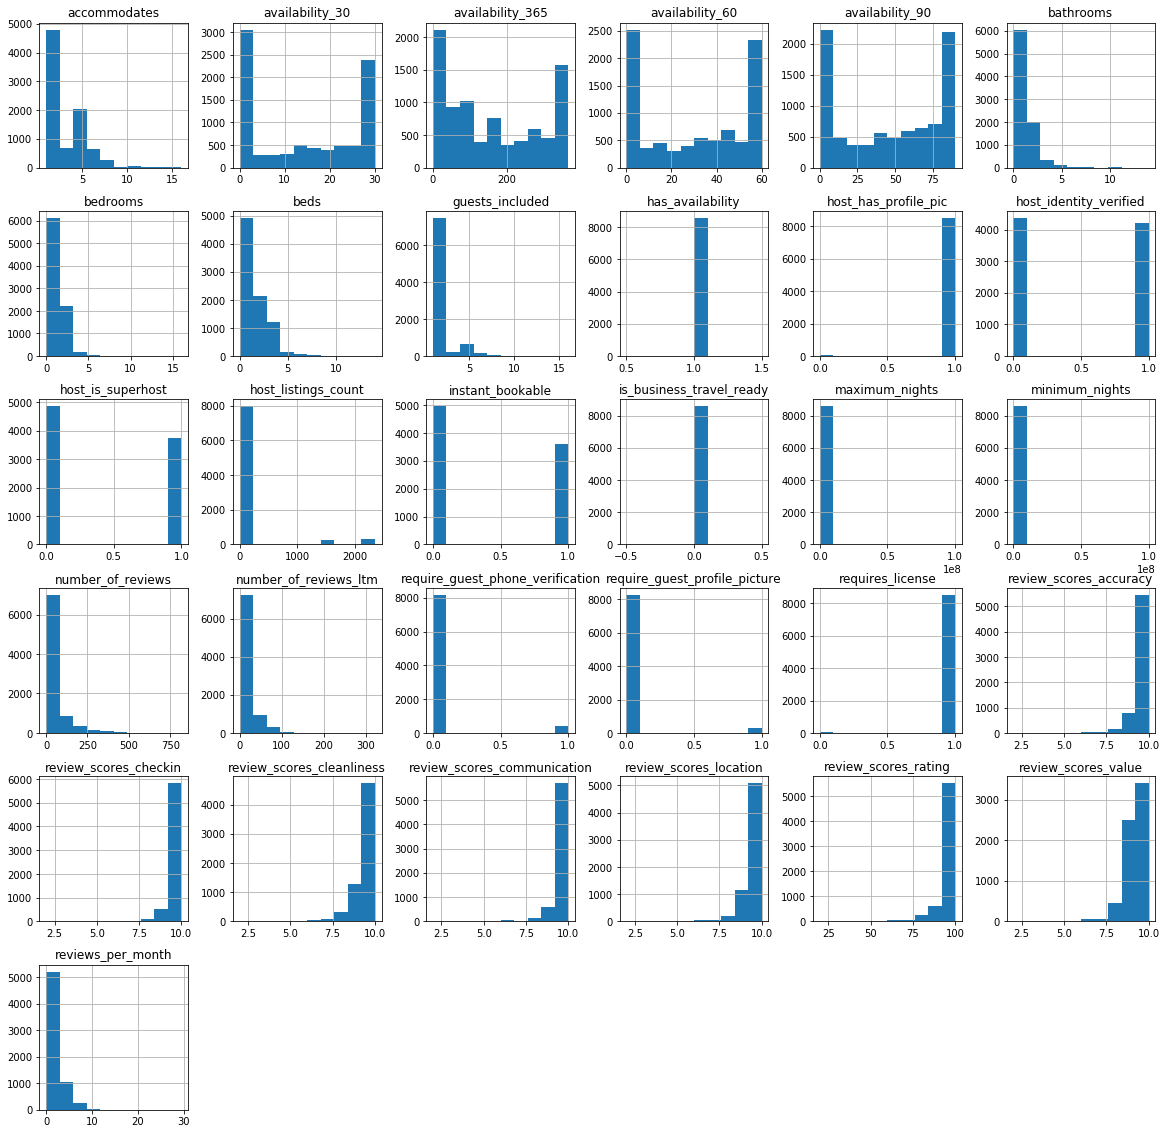

In [11]:
# Replacing columns with (t or f) to (1 or 0)
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category, or a minute margin of difference, and can be dropped:

In [12]:
df.drop(['has_availability', 'host_has_profile_pic','is_business_travel_ready','require_guest_phone_verification','require_guest_profile_picture','requires_license'], axis=1, inplace=True)

### A brief description of each column left from Pre-Processing

 - experiences_offered: in this list, all of them are "none", so an oversight on the "null value" means we could probably drop this column. 
 - host_since: date value that the host of the AirBnB host first joined
 - host_response_time: average amount of time the host takes to respond to a message
 - host_response_rate: the proportion of messages that the host replies to
 - host_acceptance_rate: how often a host accepts or declines reservations
 - host_is_superhost: whether the host is a superhost or not, which defines if the host is top-rated or has the most experience. This increases your search rankings on AirBnB
 - host_listings_count: the total number of listings a host manages
 - host_identity_verified: whether or not the host is verified with their ID
 - neighbourhood_cleansed: the neighborhood in San Francisco the listing is located in
 - property_type: type of property the listing is
 - room_type: type of listing (house, single room, etc.)
 - accomodates: number of people the listing accomodates
 - bathrooms: number of bathrooms 
 - bedrooms: number of bedrooms
 - beds: number of beds
 - bed_type: type of bed (real bed, pull-out couch, etc.)
 - amenities: list of amenities included with the listing
 - price: nighly price advertised with the listing (**this is the target variable**)
 - security_deposit: amount of money required as a security deposit
 - cleaning_fee: price for cleaning fee, which is fixed amount per booking
 - guests_included: number of guests included in the booking fees
 - extra_people: price per additional guest above the guests_included price
 - minimum_nights: minimum length of stay per booking
 - maximum_nights: maximum length of stay per booking
 - calendar_updated: when the host last updated the calendar for booking
 - availability_30: how many nights in the next 30 days that the listing is available to be booked
 - availability_60: how many nights in the next 60 days that the listing is available to be booked
 - availability_90: how many nights in the next 90 days that the listing is available to be booked
 - availability_365: how many nights in the next 365 days that the listing is available to be booked
 - number_of_reviews: the number of reviews left for the listing
 - number_of_reviews_ltm: the number of reviews left for the listing in the last 12 months
 - first_review: date of first review
 - last_review: date of last review
 - review_scores_rating: overall guest rating for the listing, on a scale of 1 to 5
 - review_scores_accuracy: guest's rating on the accuracy of the listing's description, on a scale of 1 to 5
 - review_scores_cleanliness: guest's rating on listing's cleanliness, on a scale of 1 to 5
 - review_scores_checkin: guest's rating on the check-in process, on a scale of 1 to 5
 - review_scores_communication: guest's rating of the host's communication, on a scale of 1 to 5
 - review_scores_location: guest's rating of the listing's location, on a scale of 1 to 5
 - review_scores_value: guest's rating of the listing's value for money, on a scale of 1 to 5
 - instant_bookable: whether the listing can be instantly booked or not (without having to message the host first, and wait to be accepted)
 - cancellation_policy: the type of cancellaction policy (strict, moderate, etc.)
 - reviews_per_month: calculated field of the average number of reviews left by guests each month
 

### Cleaning up individual columns


#### experiences_offered needs dropped

In [13]:
df.drop(['experiences_offered'], axis=1, inplace=True)

#### host_since

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (13 March 2020). The original column will be left in initially for EDA, and dropped later.

In [14]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2020, 3, 13) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1862.0
Median days as host: 1874.0


#### host_response_time

About an eighth of rows don't have a value for host_response_time, and the majority of these have also not yet been reviewed. Therefore this section of the dataset consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the market when considering the price for which to advertise a listing. It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. These properties listed on AirBnB could be where hosts live in the property and are put at a high price to see if any guest owuld be willing to book, or 'inactive' listings, where the calendars are completely closed. 

Because host_response_time is unknown for so many listings, it will be retained as its own category, 'unknown'.

In [15]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

Null values: 1053
Proportion: 12.3%


In [16]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.622958
within a few hours    0.148973
unknown               0.122842
within a day          0.090411
a few days or more    0.014816
Name: host_response_time, dtype: float64

#### host_response_rate

A similar story is true for host_response_rate, with about an eighth of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 80% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [17]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 1053
Proportion: 12.3%


In [18]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 96.0
Median host response rate: 100.0
Proportion of 100% host response rates: 78.2%


In [19]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       5878
unknown    1053
50-89%      759
90-99%      659
0-49%       223
Name: host_response_rate, dtype: int64

#### property_type

Analysis and Processing of property types is required as there are a large number of categories with only a few listings. The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.

In [20]:
df.property_type.value_counts()

Apartment                  3263
House                      2349
Condominium                 890
Guest suite                 595
Serviced apartment          400
Boutique hotel              336
Hotel                       167
Townhouse                   130
Loft                        105
Hostel                       77
Aparthotel                   67
Guesthouse                   48
Bed and breakfast            34
Other                        26
Cottage                      19
Resort                       16
Bungalow                     15
Villa                        12
Castle                        7
Tiny house                    5
Boat                          3
Cabin                         3
Earth house                   2
Hut                           1
In-law                        1
Cycladic house (Greece)       1
Name: property_type, dtype: int64

In [21]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Cabin': 'House',
    'Condominium': 'Apartment',
    'Guesthouse': 'House',
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [22]:
df.property_type.value_counts()

Apartment    4658
House        2583
Other        1331
Name: property_type, dtype: int64

#### bathrooms, bedrooms, and beds

to avoid fractions, we're going to fill missing values in these categories with the median number respectively

In [23]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

#### bed_type

most listings have a similar bed type so this feature can be dropped.

In [24]:
df.bed_type.value_counts()

Real Bed         8504
Futon              29
Pull-out Sofa      19
Airbed             12
Couch               8
Name: bed_type, dtype: int64

In [25]:
df.drop('bed_type', axis=1, inplace=True)

#### amenities

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [26]:
# Example of amenities listed
df.amenities[:1].values

array(['{TV,"Cable TV",Internet,Wifi,Kitchen,"Pets live on this property",Dog(s),"Free street parking",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in",Keypad,"Private entrance","Pack ’n Play/travel crib","Room-darkening shades","Hot water",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware",Oven,"Garden or backyard"}'],
      dtype=object)

In [27]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Alarm system',
 'Amazon Echo',
 'Apple TV',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Balcony',
 'Barbecue utensils',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Bread maker',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Central air conditioning',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Courtyard',
 'Crib',
 'DVD player',
 'Day bed',
 'Desk',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorm

In the list above, some amenities are more important than others (a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon ('Electric profiling bed'). Based on some research for most important amenities from a similar topic done on AirBnB markets, a portion of the more important aminities will be extracted. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (slashes indicate separate categories that can be combined):

 - 24-hour check-in
 - Air conditioning/central air conditioning
 - Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
 - BBQ grill/fire pit/propane barbeque
 - Balcony/patio or balcony
 - Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
 - Bed linens
 - Breakfast
 - Cable TV/TV
 - Coffee maker/espresso machine
 - Cooking basics
 - Dishwasher/Dryer/Washer/Washer and dryer
 - Elevator
 - Exercise equipment/gym/private gym/shared gym
 - Family/kid friendly, or anything containing 'children'
 - Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
 - Garden or backyard/outdoor seating/sun loungers/terrace
 - Host greets you
 - Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
 - Internet/pocket wifi/wifi
 - Long term stays allowed
 - Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
 - Private entrance
 - Safe/security system
 - Self check-in
 - Smoking allowed
 - Step-free access/wheelchair accessible, or anything containing 'accessible'
 - Suitable for events

In [28]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/Users/keithhancock2/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


One way to reduce the number of features (to avoid dimensionality) is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [29]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['high_end_electronics', 'nature_and_views', 'host_greeting', 'hot_tub_sauna_or_pool', 'smoking_allowed', 'accessible', 'event_suitable']


In [30]:
df.columns[41:]

Index(['bbq', 'balcony', 'bed_linen', 'breakfast', 'tv', 'coffee_machine',
       'cooking_basics', 'white_goods', 'elevator', 'gym', 'child_friendly',
       'parking', 'outdoor_space', 'internet', 'long_term_stays',
       'pets_allowed', 'private_entrance', 'secure', 'self_check_in'],
      dtype='object')

#### price, security_deposit, cleaning_fee, and extra_people

These variables need to be converted to an integer from a string, because there are dollar signs 

If values are null (0), then they will be replaced with the integer 0 because it's essentially a $0 value for the respective fee

In [31]:
#price
df.price = df.price.str.replace('[\$\,]|\.\d*', '').astype(float)
#security_deposit
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype(float)
#cleaning_fee
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype(float)
#extra_people
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype(float)

#### calendar_updated

In [32]:
print("Number of categories:", df.calendar_updated.nunique())

Number of categories: 68


We are going to drop the 'calendar_updated' column because it's unclear as to what this variable adds to the model. There could be multiple reasons as to why a host would update their calendar

In [33]:
df.drop('calendar_updated', axis=1, inplace=True)

#### availability 

In San Francisco, Under existing law, anyone in the City of San Francisco listing a residential property for short-term rent (less than 30 nights at a time) on a hosting platform like Airbnb must register for a Short-Term Residential Rental Certificate and Business Registration Certificate. Because of this, we will only keep the availability_30 variable for this model.

In [34]:
df.drop(['availability_60', 'availability_90', 'availability_365'], axis=1, inplace=True)

#### first_review and last_review

About a quarter of listings (~24%) have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and that could affect overall price.

This is too large a proportion of the dataset to replace with median/mean values, because it would skew the distribution. The missing values here are not really missing values; it tells us that these are new or previously unbooked listings that have not had reviews yet. To make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, it's beneficial to keep them in. 

These will be kept as an 'unknown' category, and the feature will have to be treated as categorical, and will be 'one-hot' encoded.

Below is a distribution of the number of days since the first review. 

In [35]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 23.3%
Null values in 'review_scores_rating': 23.9%


In [36]:
# Converting to datetime
df.first_review = pd.to_datetime(df.first_review) 

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2020, 3, 13) - df.first_review).astype('timedelta64[D]')

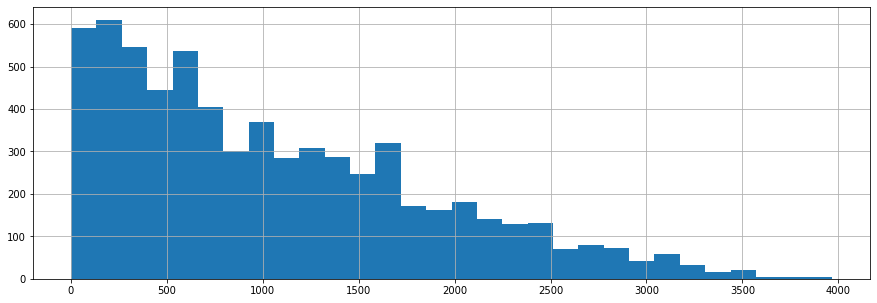

In [37]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30)

We will create a function to bin the columns of first and last reviews into appropriate time spans (0-6 months, 6-12 months, 1-2 years, 2-3 years, 4+ years)

We will end up dropping the last_review because of the distribution. first_review will be kept for later analysis. 

In [38]:
def bincolumn(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls with 'unknown' if there's no specific value.
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [39]:
# Binning time since first review
bincolumn('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [40]:
# Converting to datetime
df.last_review = pd.to_datetime(df.last_review) 

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2020, 3, 13) - df.last_review).astype('timedelta64[D]')

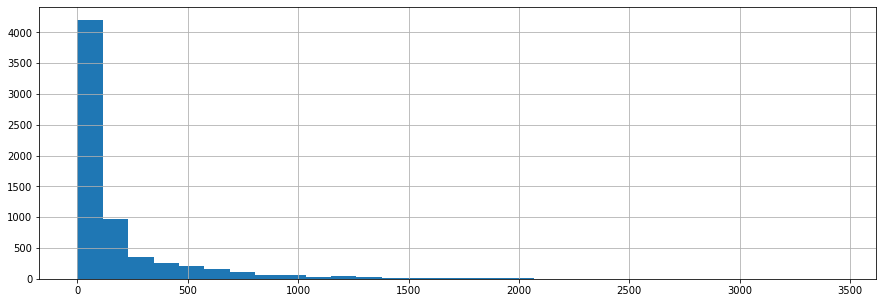

In [41]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30)

In [42]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2020, 3, 13) - df.last_review).astype('timedelta64[D]')

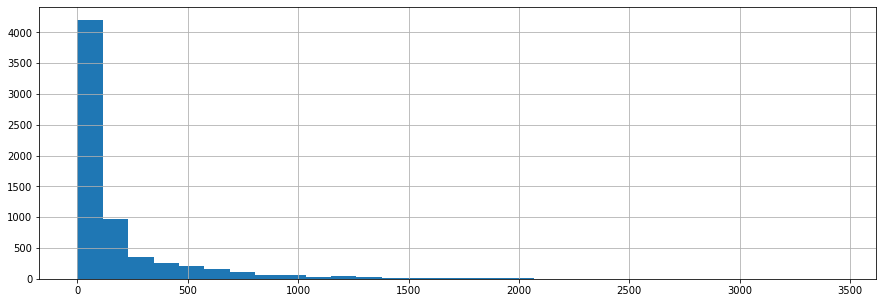

In [43]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [44]:
# Binning time since last review
bincolumn('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [45]:
# Dropping last_review 
df.drop('last_review', axis=1, inplace=True)

#### review ratings columns

As above, listings without reviews will be kept and replaced with 'unknown'. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together. By AirBnB standards, these are considered a 'low rating'.

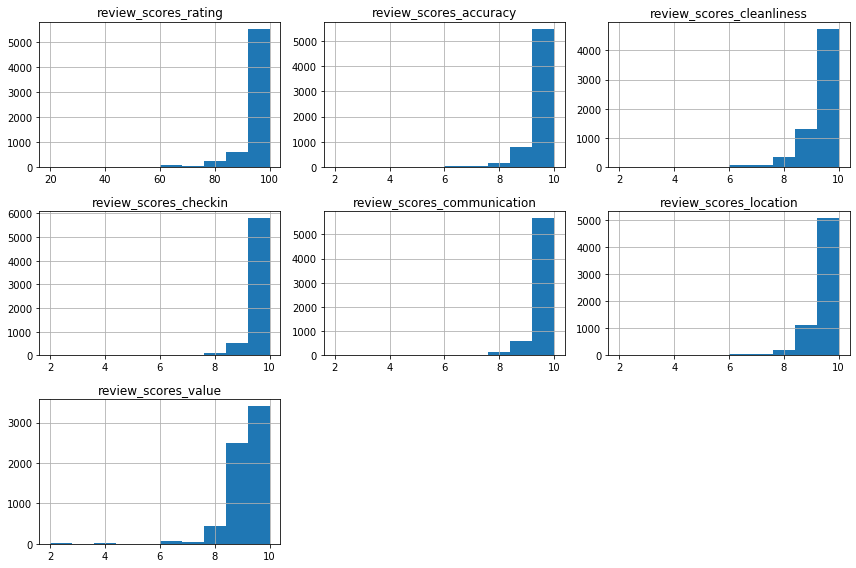

In [46]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [47]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [48]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bincolumn(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [49]:
bincolumn('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

#### cancellation_policy

We need to clean up the cancellation_policy variable in order to categorize the categories into the three larger categories (the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [50]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    3883
moderate                       2577
flexible                       1927
strict                          114
super_strict_30                  46
super_strict_60                  18
luxury_moderate                   7
Name: cancellation_policy, dtype: int64

In [51]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

#### number_of_reviews_ltm and reviews_per_month

These will end up correlated with number_of_reviews and will be dropped.

In [52]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

# Exporatory Data Analysis

### Time series

The oldest San Francisco listing that is currently live on Airbnb was first listed on the site in March 2008. From 2011 onwards, the number of listings started increasing considerably. However, growth in the number of new hosts (of those currently listing on the site) has been decreasing since 2017, likely because of the Pass-Through Registration (PTR) system that asks for hosts to apply for a Short-Term Residential Rental Certificate and Business Registration Certificate.

A high level of seasonality is evident, with notable peaks in the summer when people put properties online to take advantage of the increased number of tourists. Notably, there is also a big peak in the number of hosts joining Airbnb in 2016.

In [53]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 03 March 2008, and the most recent joined on 10 March 2020.


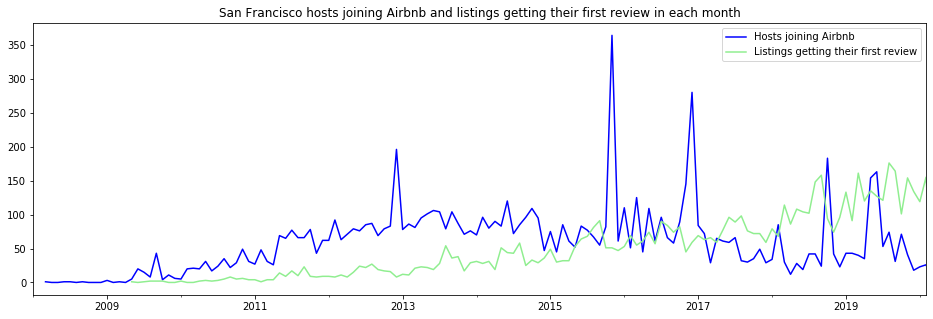

In [54]:
plt.figure(figsize=(16,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='blue')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='lightgreen')
plt.title('San Francisco hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-01-01', '2020-02-01') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [55]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [56]:
# define functoin for decomposition of time in the series for trend, seasonal, and residual analysis.
def decompose_time(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

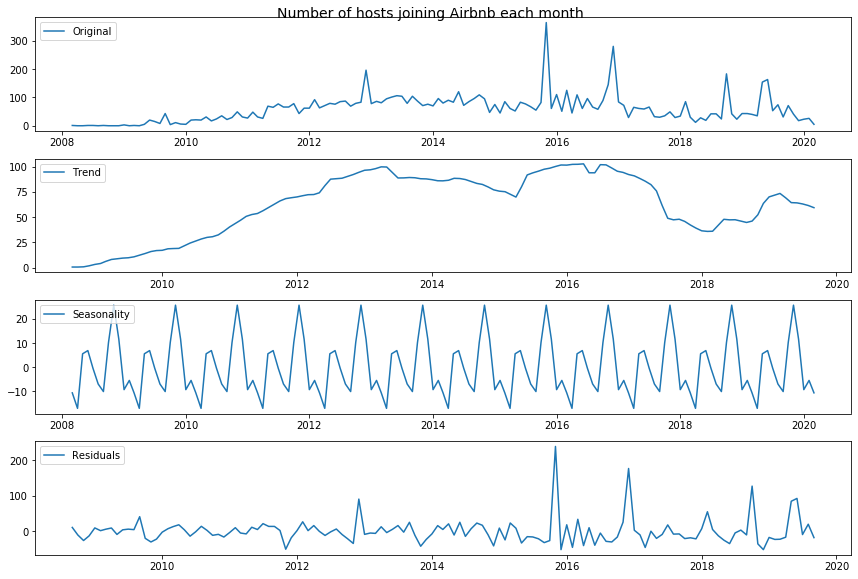

In [57]:
decompose_time(ts_host_since, title='Number of hosts joining Airbnb each month')

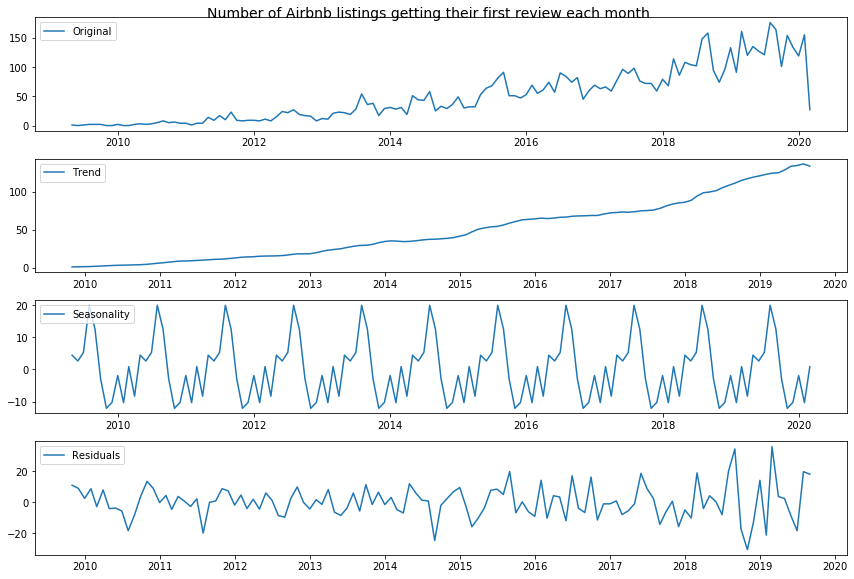

In [58]:
decompose_time(ts_first_review, title='Number of Airbnb listings getting their first review each month')

### Mass-Hosting 

There are increasing numbers of professional Airbnb management companies that host a large number of listings under a single host profile, particularly from 2015 onwards. 

/Users/keithhancock2/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/keithhancock2/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1237: RuntimeWarning: invalid value encountered in double_scalars
  notch_max = med + 1.57 * iqr / np.sqrt(N)


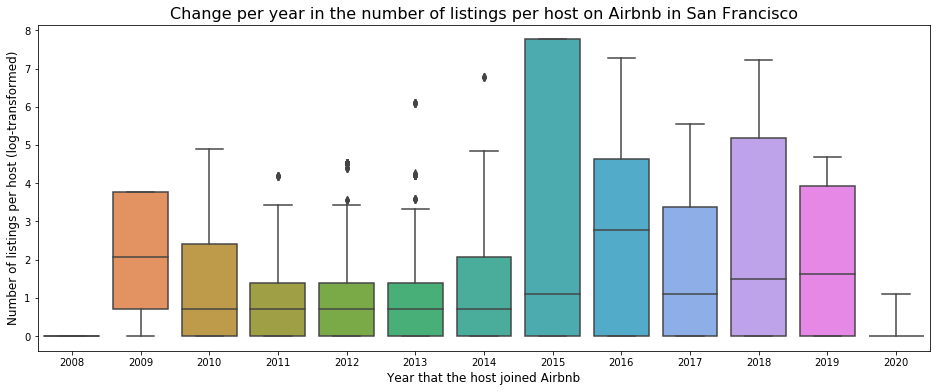

In [59]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in San Francisco', fontsize=16)
plt.show()

In [60]:
print("Average number of listings per host per year on Airbnb in San Francisco:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in San Francisco:
host_since
2008-01-01      1.00
2009-01-01     18.25
2010-01-01     12.25
2011-01-01      5.73
2012-01-01     13.05
2013-01-01     10.86
2014-01-01     15.57
2015-01-01    661.23
2016-01-01    317.21
2017-01-01     21.62
2018-01-01     61.55
2019-01-01     23.51
2020-01-01      0.52
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [61]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
13811042,2010-04-04,135
32525042,2018-10-10,180
31188284,2016-10-18,221
23452479,2017-04-19,254
28073566,2013-10-14,440
14246713,2015-03-30,684
20426652,2014-02-14,883
32105198,2018-06-11,1364
29000480,2016-12-16,1437


### Price Changes

The average price per night for Airbnb listings in San Francisco has increased minimally over the last 11 years. In particular, the top end of property prices has increased, resulting in a larger increase in the mean price compared to the median. 

/Users/keithhancock2/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


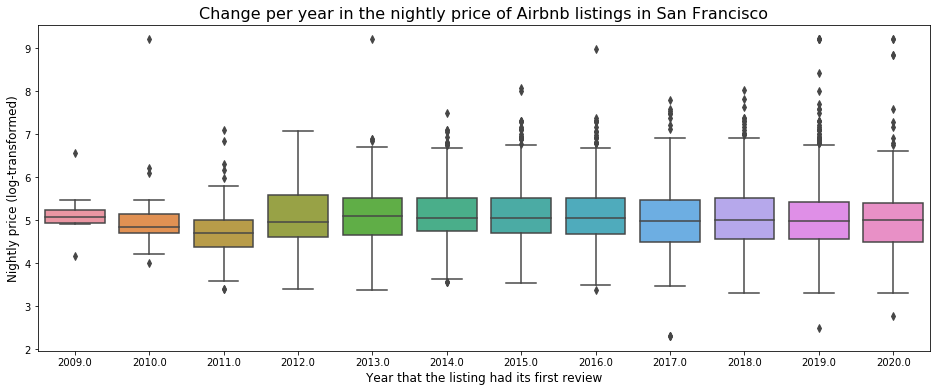

In [62]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in San Francisco', fontsize=16)
plt.show()

In [63]:
print("Mean nightly price of listings in each year on Airbnb in San Francisco:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in San Francisco:
first_review
2009-01-01    223.12
2010-01-01    396.72
2011-01-01    148.17
2012-01-01    209.88
2013-01-01    240.04
2014-01-01    215.87
2015-01-01    232.06
2016-01-01    227.43
2017-01-01    201.21
2018-01-01    209.67
2019-01-01    237.26
2020-01-01    310.33
Name: price, dtype: float64


In [64]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

### Numerical Features

In [65]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,...,gym,child_friendly,parking,outdoor_space,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in
count,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,...,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000,8572.000000
mean,0.434438,144.744517,0.490201,3.106043,1.406265,1.323728,1.707769,227.820929,352.751750,101.060079,...,0.141974,0.328745,0.633691,0.253383,0.984951,0.314512,0.214069,0.427322,0.141157,0.490201
std,0.495712,487.268229,0.499933,1.895983,0.949607,0.928091,1.189489,457.656486,696.330685,97.297035,...,0.349044,0.469784,0.481823,0.434974,0.121755,0.464348,0.410199,0.494718,0.348204,0.499933
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,99.000000,0.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,150.000000,100.000000,80.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,18.000000,1.000000,4.000000,1.500000,2.000000,2.000000,240.000000,500.000000,150.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,2345.000000,1.000000,16.000000,14.000000,16.000000,14.000000,10000.000000,5100.000000,1350.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Price

Price can range from 0 to 10,000 dollars per night in San Francisco. The extreme end of this distribution could be due to hosts not knowing how to use AirBnB-advertised prices (sticker prices). The prices themselves can be set to any arbitrary amount, and these are the prices that show when dates are not on the site. (think about if you've been on Craigslist, Facebook Marketplace, or a similar buy/sell platform, and the actual price is in the details of a listing, instead of the advertised price)

Unfortunately this model will be predicting advertised prices rather than the prices actually paid. Nevertheless, some cleaning of the particularly unhelpful values will be done. Very small values under 10 will be increased to 10.

There are notable drop-offs in nightly prices at around 200 (first graph, orange line), 300 (second graph, orange line) and 1,100 (second graph, red line). Values above 1,500 will be reduced to 1,500.

In [66]:
print(f"Nightly advertised prices range from ${min(df.price)} to ${max(df.price)}.")

Nightly advertised prices range from $0.0 to $10000.0.


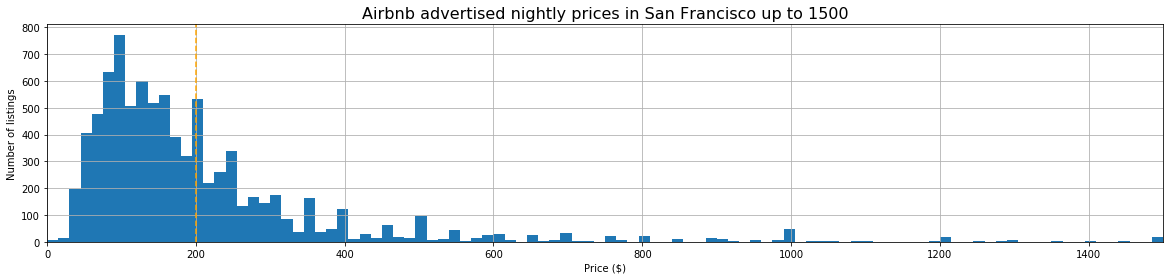

In [67]:
# Distribution of prices from 0 to 1500
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1500))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in San Francisco up to 1500", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

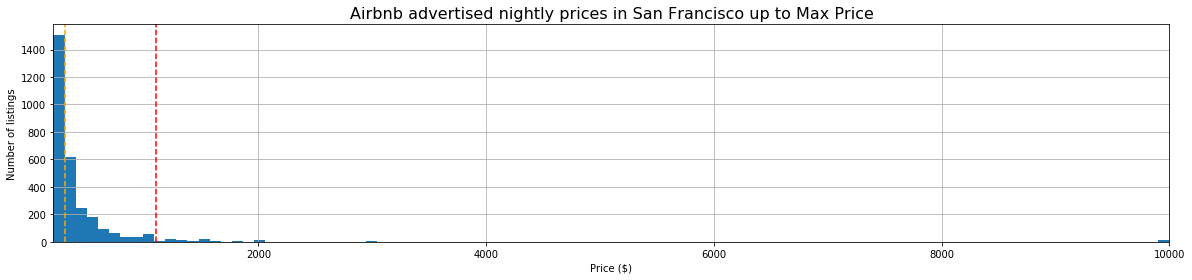

In [68]:
# Distribution of prices from $200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(300, color='orange', linestyle='--')
plt.axvline(1100, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in San Francisco up to Max Price", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [69]:
# Replacing values under $10 with $10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over $1000 with $1000
df.loc[df.price >= 1500, 'price'] = 1500

#### host listings count

The median number of listings that the host of each listing has is 3. The mean is much, much higher (145) due to some hosts managing large numbers of listings (as discussed above in the Time Series section).

Two difficulties in discerning how many listings hosts have on average are:

- this number is only known on the level of the listing, so hosts with more listings are represented more frequently (host with 10 listings may be represented up to 10 times in the dataset)
- a host's other listings may not be in San Francisco so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [70]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 3
Mean number of listings per host: 145
29% of listings are from hosts with one listing.


#### Persons accommodated, bathrooms, bedrooms and beds

The most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher nightly rates, with diminishing returns coming after about 8-10 people. Overall though, price fluctuates greatly after 8 people. (15-person accomodation has a similar price to 8 people, for example)

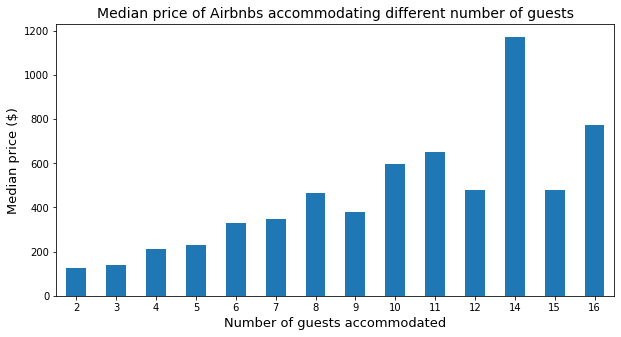

In [71]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

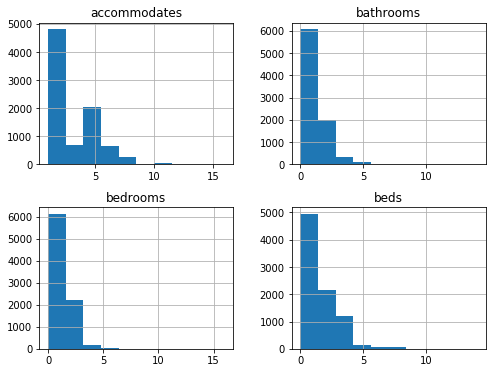

In [72]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

### Categorical Features

Categorical features will be explored and plotted to gain insight and determine whether or not they should be included in the final model.

#### Property and Room Types

54% of properties are apartments. The remainder are houses or more uncommon property types 'bed and breakfast' or 'yurt').

About 60% of listings are entire homes (renting the entire property on your own). Most of the remainder are private rooms (renting a bedroom and possibly also a bathroom, but there will be other people in the property). the remaining 4% are shared rooms or hotel rooms(sharing a room with either the property owner or other guests, or an AirBnB listing for a hotel room).

In [73]:
def category_count(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

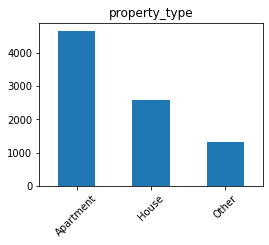

Apartment    0.543397
House        0.301330
Other        0.155273
Name: property_type, dtype: float64


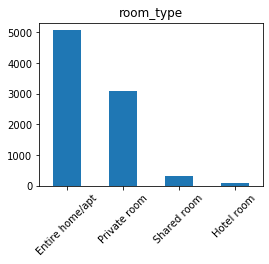

Entire home/apt    0.590877
Private room       0.360943
Shared room        0.036514
Hotel room         0.011666
Name: room_type, dtype: float64


In [74]:
for col in ['property_type', 'room_type']:
    category_count(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

#### Reviews

for every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall). Ratings of 8 or below are few and far between. 

Guests seem to be most positive about communication, check-ins and accuracy. There's a considerable number of listings that have not been reviewed as well. 

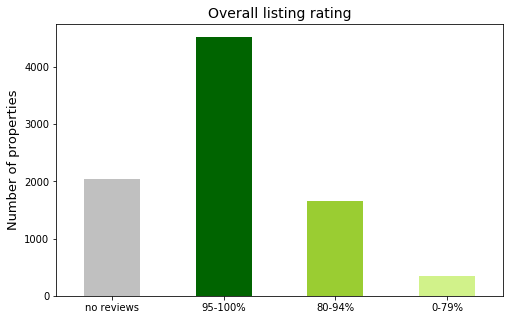

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

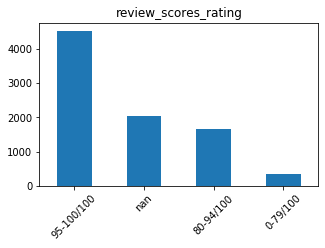

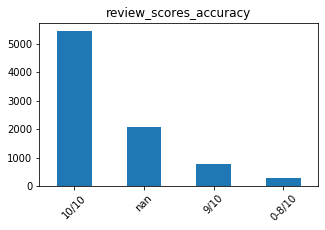

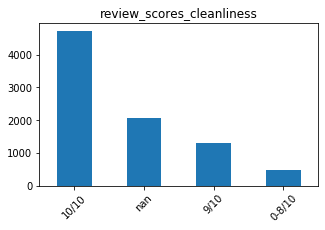

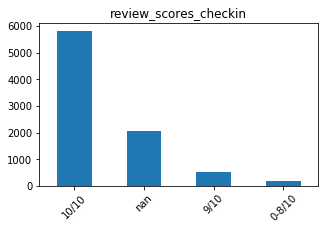

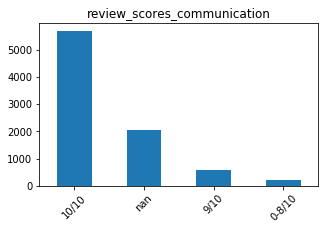

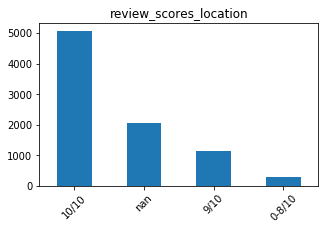

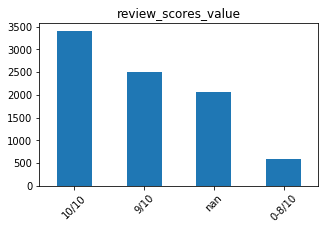

In [76]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count(col, figsize=(5,3))

#### First and last reviews

the most frequent time period in which live AirBnB listings had their first review is 4+ years, and close to that is 2-3 years. This means that a lot of listings on the site have been active for at least 4 years. Relatively few have been active for less than 6 months.

The most common category for the time since a listing received its last review is 2-8 weeks. This means that a lot of listings have been reviewed relatively recently.

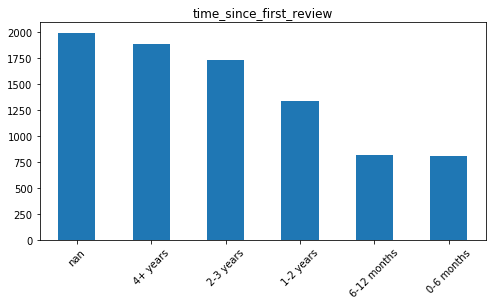

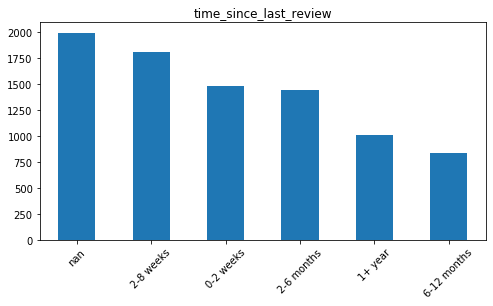

In [77]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count(col)

### Boolean (t/f) Features

Features can be true or false. This portion compares the proportions of these features that are true or false (to explore the data and also to ascertain whether the feature is worth retaining), and the median price of each category (to explore the relationship between the category and price).

In [78]:
# define function for a bar chart to count t/f categories in the specified column, 
# displayed next to a bar chart of the median price for each category

def binary_count_price_plot(col, figsize=(8,3)):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['red', 'lightblue'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['red', 'lightblue'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)')
    ax2.set_xlabel('')
    
    plt.show()

#### Superhosts

about 43% of hosts are superhosts. It seems it might slightly improve the median price per night of their Airbnb listings, so it is arguable whether or not it is worth it in a financial perspective.

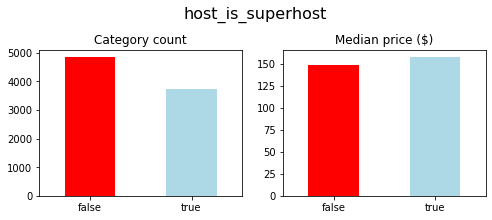

0    0.565562
1    0.434438
Name: host_is_superhost, dtype: float64


In [79]:
binary_count_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

#### Host verification

It seems that it's an even split between verified and non-verified hosts (verifications: ID, phone number, email address). 

Despite the fact that you could expect the additional trust with a verified hosts to result in higher nightly prices, there is little difference between the median nightly prices of listings with verified and unverified hosts. This column will be left in the dataframe, however, in case it has any useful interactions with other features.

In [80]:
df.host_identity_verified.value_counts(normalize=True)

0    0.509799
1    0.490201
Name: host_identity_verified, dtype: float64

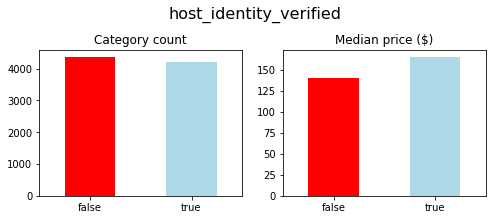

In [81]:
binary_count_price_plot('host_identity_verified')

#### Instant Booking

About 42% of properties are instant bookable. However, the added convenience does not seem to have any major effect on the median price per night.

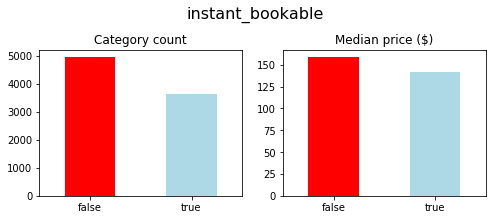

0    0.578045
1    0.421955
Name: instant_bookable, dtype: float64


In [82]:
binary_count_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

#### Amenities

- check_in_24h: there's a very small amount of listings with 24-hour check in available. this might have a small affect on price. 
- air_conditioning: this seems to be an uncommon amenity. **In San Francisco, air conditioning is not present in many of the residences, offices, theaters as well as older, boutique style hotels. According to weather.com, the warmest month on average is September with an average high of 71 and low of 56. This being known, it may not have a great effect on price.**
- bbq: having an amenity related to grilling seems to have a noticable impact on price.
- balcony: similar to bbq, having a balcony may have a noticable impact on price. 
- bed_linen: no noticeable difference
- breakfast: no noticeable difference
- tv: this seems to be a crucial amenity to having a higher median price. most listings do offer TV as an amenity.
- coffee_machine: this does seem to have an affect on median price. most listings have this amenity. 
- cooking_basics: no noticeable difference
- white_goods: (refrigerators, washing machines, and other major appliances) most listing offer this amenity, and it seems to increase median price.
- elevator: this is more likely to be included with hotel listings (small majority) or large-square-foot listings (mansion, castle, etc). most listings do not have it, but it might make a difference in median price. 
- gym: most listings do not include a gym, but having this amenity looks like it increases median price. 
- child_friendly: most listings in San Francisco are not child friendly, but being child friendly looks like it increases price. 
- parking: most listings include this amenity, and it might have a marginal effect on price. 
- outdoor_space: most lsitings do not have outdoor space, but it could potentially increase price if included.
- internet: almost all listings include internet, and it does increase price. 
- long_term_stays: most listings do not provide long term stays, and it does not affect price overall.
- pets_allowed: most listings are, **unfortunately**, not pet friendly. Having this amenity seems to increase price. 
- private_entrance: fewer listings have a private (gated or protected) entrance, but having this amenity coudl increase price.
- secure: this seems to be similar to private_entrance. We're assuming this means some kind of security system in place. it does not affect price much. 
- self_check_in: there's close to a 50/50 split in listings that have/do not have self-check-in as an option. it does potentially increase median price though. 

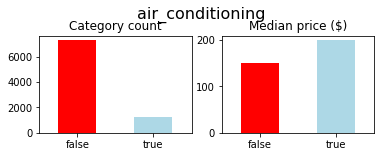

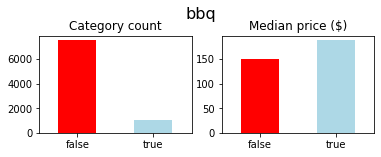

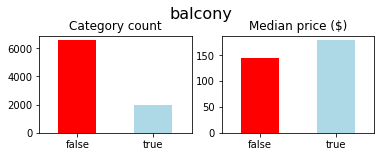

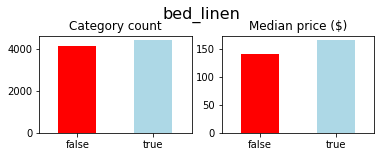

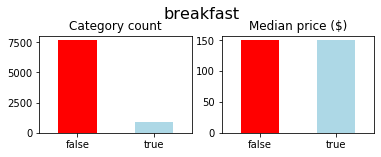

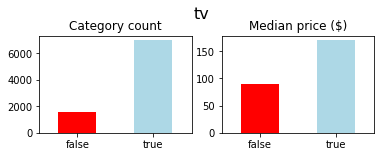

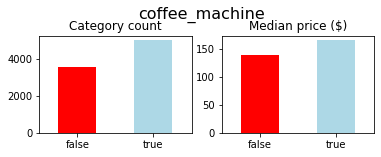

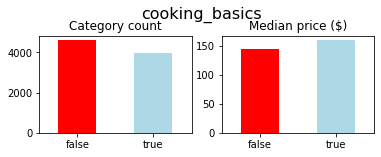

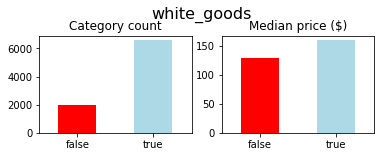

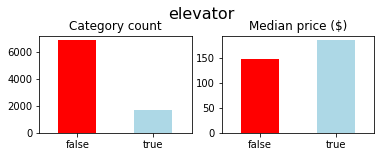

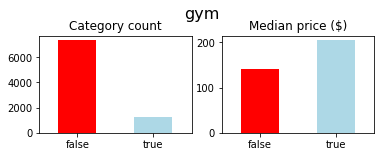

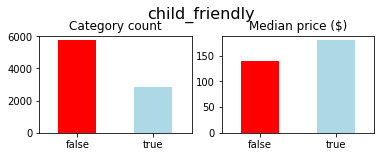

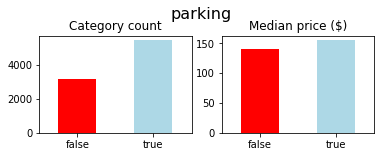

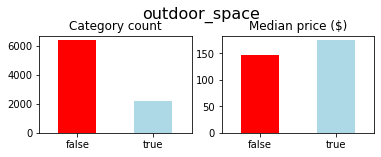

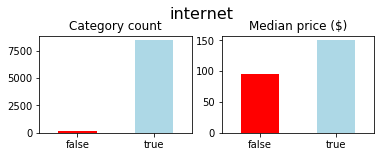

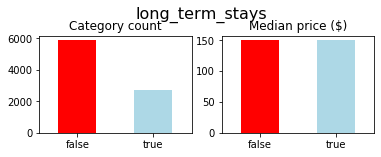

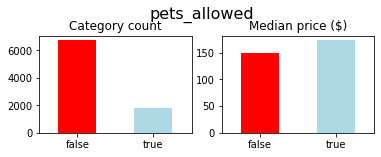

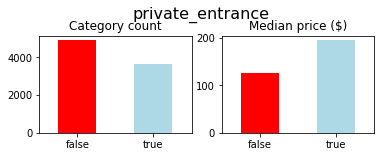

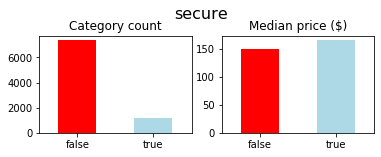

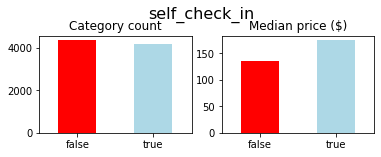

In [83]:
for col in df.iloc[:,31:-2].columns:
    binary_count_price_plot(col, figsize=(6,2))

# Preparing the data for Modeling

#### Dropping columns and assessing multi-collinearity

In [84]:
#one-hot encoding for categorical variables
transformed_df = pd.get_dummies(df)

In [85]:
def collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

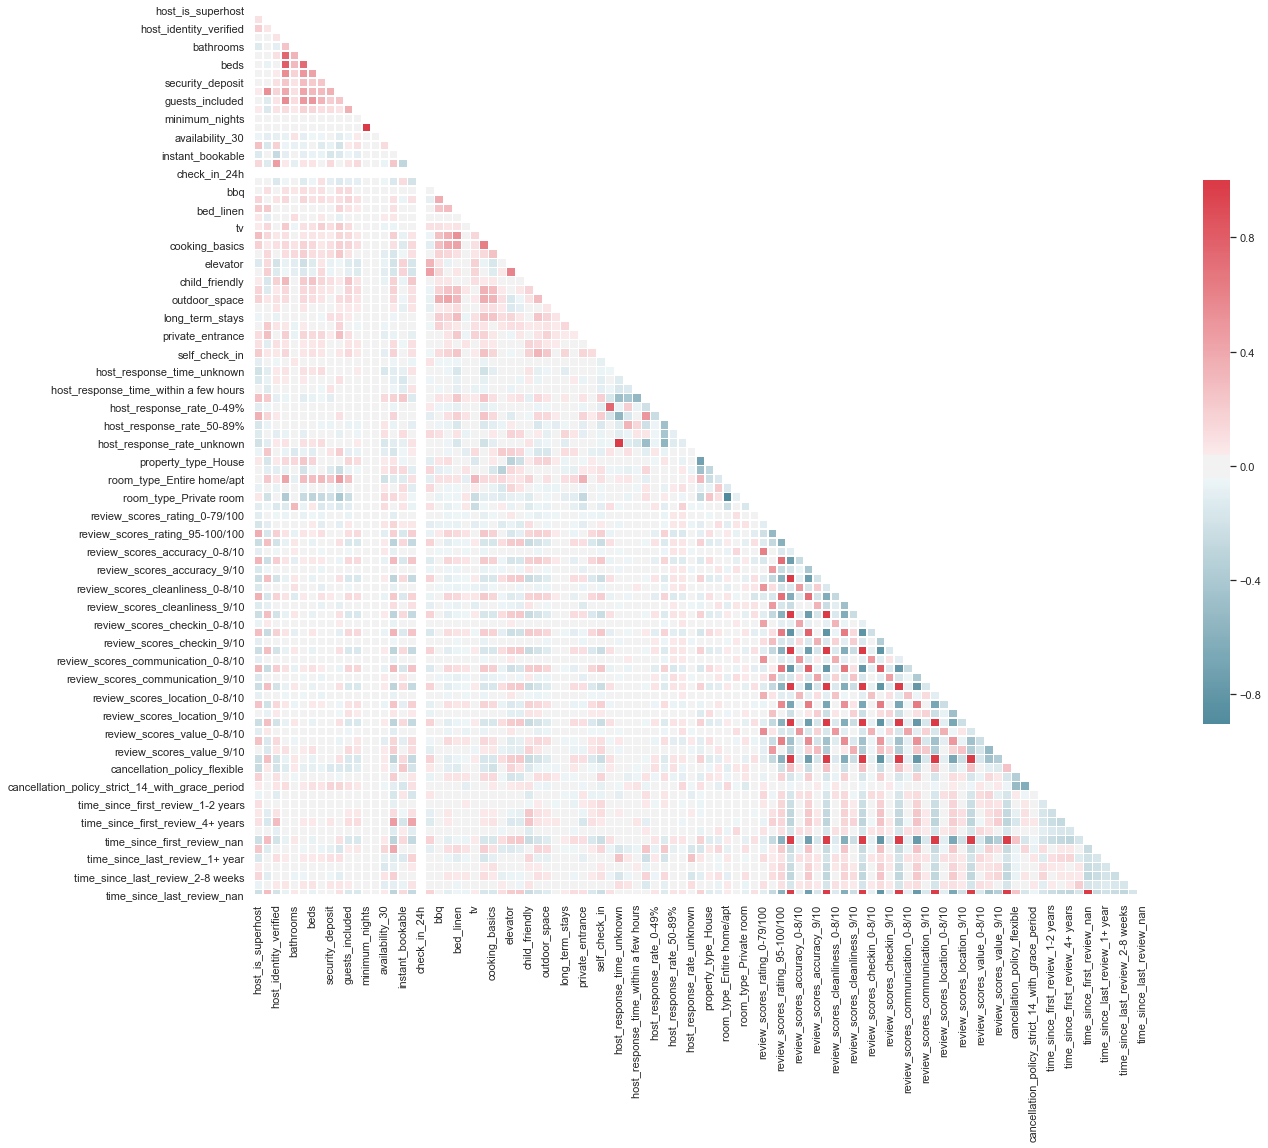

In [86]:
collinearity_heatmap(transformed_df, figsize=(20,20))

Areas of multi-collinearity:

- Beds, bedrooms, guests included and the number of people (top of produced heatmap) that a property accommodates are highly correlated. The number of people accommodated is a more high priority search parameter on AirBnB, as it is more relevant for private and shared rooms than the number of bedrooms.
- Tthere are perfect correlations between NaN reviews (listings that are not reviewed yet) for different review categories, and first and last review times. NaN categories can therefore be dropped.
- The same is true of unknown host response rates and times. One of these (rate) will be dropped.
- There is a correlation between a 0-49% response rate, and an average response time of a few days or more. One of these (rate) will be dropped.
- There are strong negative correlations between houses and apartments, and between private rooms and entire homes (as these were the main two categories of their features before they were one-hot encoded). Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

In [87]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room',
           'check_in_24h']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

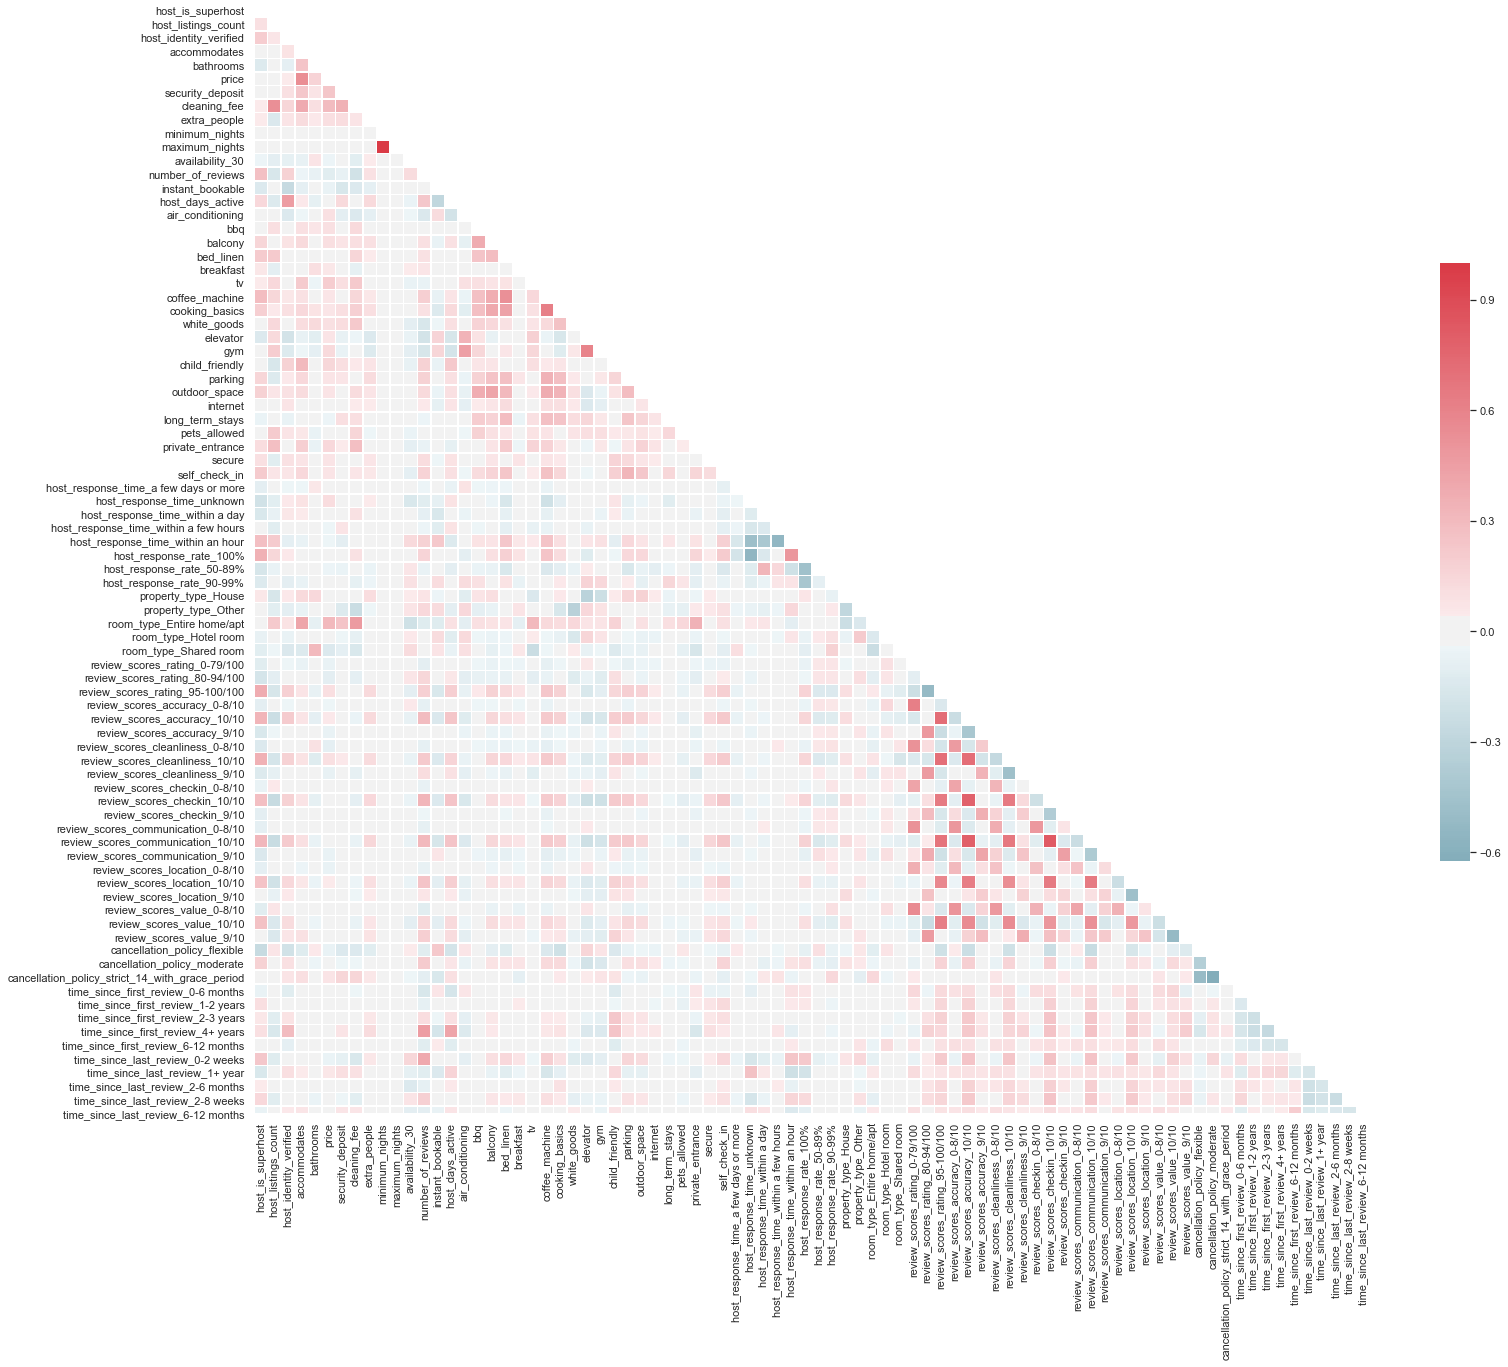

In [88]:
# Final assessment of multi-collinearity
collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

There are still some fairly strong correlations between highly rated properties of different reviews categories (if a property gets a 10/10 for one category, it is likely to get a 10/10 for other categories). However, these will be left in for now and can be experimented with later to see if removing them improves the model.

#### Standardizing and normalizing

In [89]:
numerical_columns = ['accommodates', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1452ed750>,
      dtype=object)

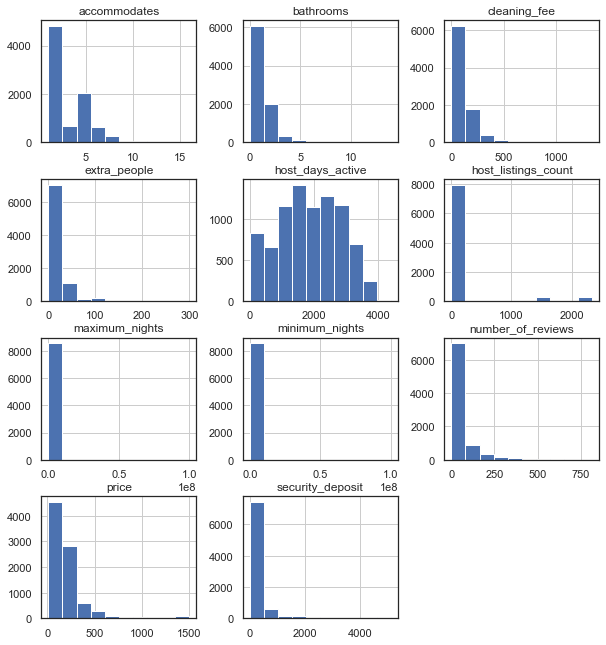

In [90]:
transformed_df[numerical_columns].hist(figsize=(10,11))

In [91]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14597f510>,
      dtype=object)

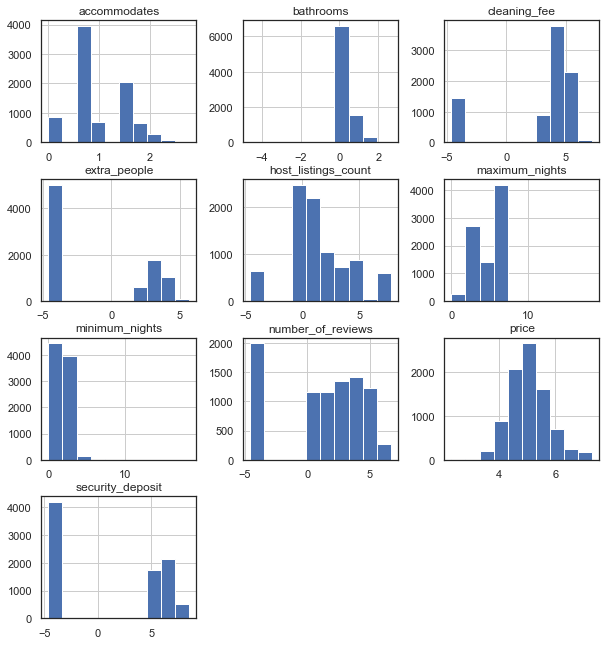

In [92]:
transformed_df[numerical_columns].hist(figsize=(10,11))

#### Separating and scaling X and Y 

In [93]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Building the Neural Networks

In this section we'll be using neural network models to predict an Airbnb listing's price.

The evaluation metrics used will be mean squared error (for loss) and r squared (for accuracy).

In [94]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Model 1: Xgboost

Before building a neural network, a vanilla XGBoost model will be used to predict price, in order to provide a baseline level of accuracy and a measure of feature importance. This most give the best achievable accuracy (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's performance.

In [95]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[22:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.1 minutes

Training MSE: 0.1382
Validation MSE: 0.1668

Training r2: 0.7289
Validation r2: 0.6731


In [96]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
review_scores_accuracy_0-8/10,0.000000
long_term_stays,0.000000
coffee_machine,0.000000
bed_linen,0.000000
host_response_time_a few days or more,0.000000
bbq,0.000000
time_since_last_review_2-8 weeks,0.000000
review_scores_rating_0-79/100,0.000000
outdoor_space,0.000000
review_scores_checkin_0-8/10,0.000000


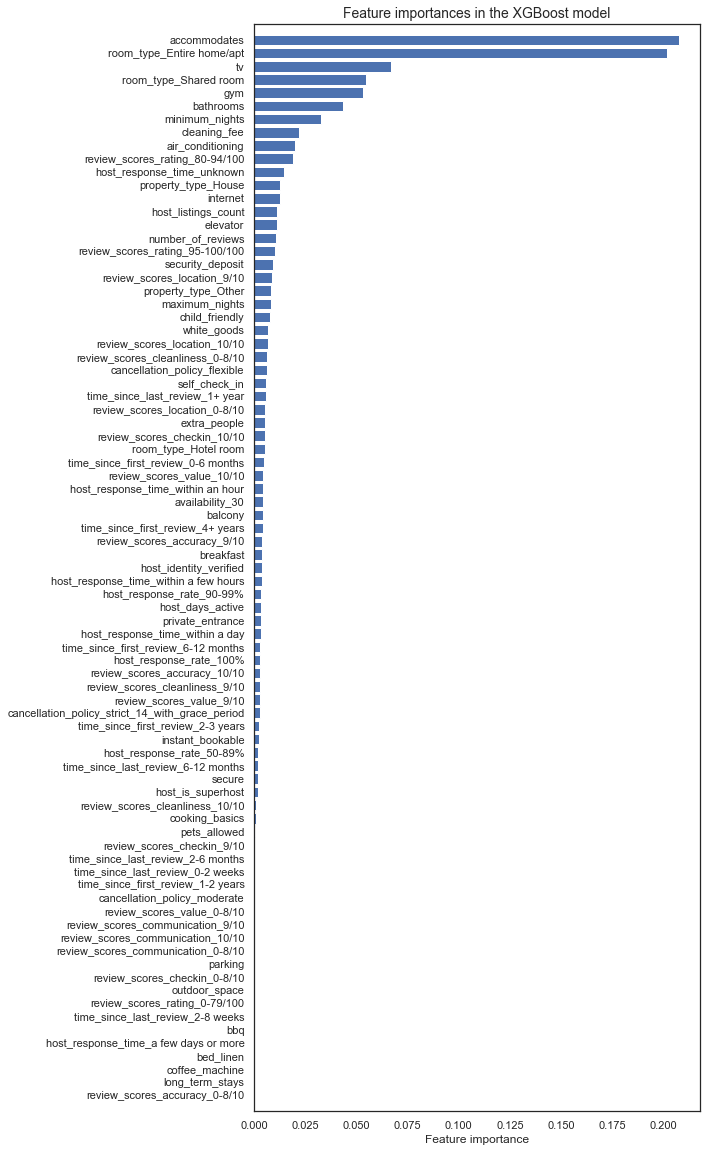

In [97]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

#### The top 10 most important features are:

- How many people the property accommodates
- Room Type - entire home/apartment
- TV amenity availability
- if the listing is a 'shared room'
- Gym amenity availability
- The number of bathrooms
- Minimum nights stay
- The cleaning fee
- Air conditioning amenity
- review scores ranging from 80-94, out of 100


There seems to be a heavy importance on amenities available and the number of people a listing accomodates (you could say bathrooms being an influence on that as well). Also of importance is the type of listing - seeing if the listing is an entire home/apartment or a shared room.

### Model 2: three layer neural network

For the initial version of the neural network, a relatively shallow three layer NN will be created. It will consist of densely-connected layers, and use a relu (rectified linear unit) activation function for the hidden layers and a linear activation function for the output layer, as it is being used for a regression task. The loss function will be mean squared error.

In [98]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               10496     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 109,569
Trainable params: 109,569
Non-trainable params: 0
_________________________________________________________________
None


#### Training the model

In [99]:
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=250,
                  batch_size=128,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Train on 6171 samples, validate on 686 samples
Epoch 1/250
6171/6171 [==============================] - 0s 63us/step - loss: 2.9475 - mean_squared_error: 2.9475 - val_loss: 0.3963 - val_mean_squared_error: 0.3963
Epoch 2/250
6171/6171 [==============================] - 0s 39us/step - loss: 0.3021 - mean_squared_error: 0.3021 - val_loss: 0.2941 - val_mean_squared_error: 0.2941
Epoch 3/250
6171/6171 [==============================] - 0s 39us/step - loss: 0.2372 - mean_squared_error: 0.2372 - val_loss: 0.2659 - val_mean_squared_error: 0.2659
Epoch 4/250
6171/6171 [==============================] - 0s 38us/step - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2521 - val_mean_squared_error: 0.2521
Epoch 5/250
6171/6171 [==============================] - 0s 38us/step - loss: 0.1820 - mean_squared_error: 0.1820 - val_loss: 0.2507 - val_mean_squared_error: 0.2507
Epoch 6/250
6171/6171 [==============================] - 0s 36us/step - loss: 0.1694 - mean_squared_error: 0.1694 - val_los

Epoch 50/250
6171/6171 [==============================] - 0s 49us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.2778 - val_mean_squared_error: 0.2778
Epoch 51/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.2722 - val_mean_squared_error: 0.2722
Epoch 52/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.2819 - val_mean_squared_error: 0.2819
Epoch 53/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.2784 - val_mean_squared_error: 0.2784
Epoch 54/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.2784 - val_mean_squared_error: 0.2784
Epoch 55/250
6171/6171 [==============================] - 0s 37us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.2791 - val_mean_squared_error: 0.279

6171/6171 [==============================] - 0s 36us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.2547 - val_mean_squared_error: 0.2547
Epoch 100/250
6171/6171 [==============================] - 0s 37us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.2507 - val_mean_squared_error: 0.2507
Epoch 101/250
6171/6171 [==============================] - 0s 36us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.2566 - val_mean_squared_error: 0.2566
Epoch 102/250
6171/6171 [==============================] - 0s 34us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.2536 - val_mean_squared_error: 0.2536
Epoch 103/250
6171/6171 [==============================] - 0s 33us/step - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.2552 - val_mean_squared_error: 0.2552
Epoch 104/250
6171/6171 [==============================] - 0s 42us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.2506 - val_mean_squared_error: 0.2506
Epoch 

Epoch 148/250
6171/6171 [==============================] - 0s 36us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.2397 - val_mean_squared_error: 0.2397
Epoch 149/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.2379 - val_mean_squared_error: 0.2379
Epoch 150/250
6171/6171 [==============================] - 0s 34us/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.2392 - val_mean_squared_error: 0.2392
Epoch 151/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.2343 - val_mean_squared_error: 0.2343
Epoch 152/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.2358 - val_mean_squared_error: 0.2358
Epoch 153/250
6171/6171 [==============================] - 0s 34us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.2394 - val_mean_squared_error:

Epoch 197/250
6171/6171 [==============================] - 0s 36us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.2257 - val_mean_squared_error: 0.2257
Epoch 198/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.2249 - val_mean_squared_error: 0.2249
Epoch 199/250
6171/6171 [==============================] - 0s 34us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.2262 - val_mean_squared_error: 0.2262
Epoch 200/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.2240 - val_mean_squared_error: 0.2240
Epoch 201/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.2221 - val_mean_squared_error: 0.2221
Epoch 202/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.2308 - val_mean_squared_error:

Epoch 246/250
6171/6171 [==============================] - 0s 33us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.2200 - val_mean_squared_error: 0.2200
Epoch 247/250
6171/6171 [==============================] - 0s 33us/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.2179 - val_mean_squared_error: 0.2179
Epoch 248/250
6171/6171 [==============================] - 0s 33us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.2207 - val_mean_squared_error: 0.2207
Epoch 249/250
6171/6171 [==============================] - 0s 33us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.2200 - val_mean_squared_error: 0.2200
Epoch 250/250
6171/6171 [==============================] - 0s 35us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.2146 - val_mean_squared_error: 0.2146
Time taken to run: 1.0 minutes


In [100]:
def score_eval(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):


    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    

def model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):


    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.0263
Validation MSE: 0.2084

Training r2: 0.9484
Validation r2: 0.5915


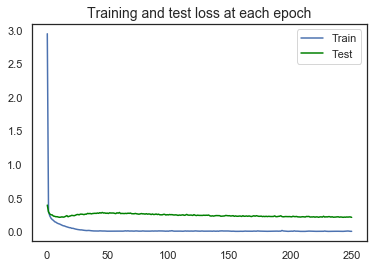

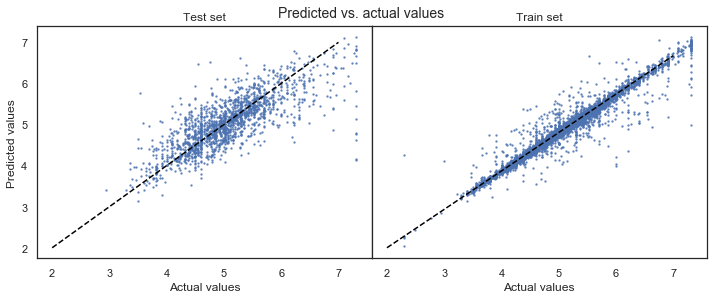

In [101]:
model_evaluation(nn2)

Compared to the XGBoost model, the neural network has performed worse. The training set had much better results in the neural network, indicating that overfitting is an issue.

### Model 3: four-layer neural network with L1 regularization and more epochs

To try and reduce over-fitting, L1 regularization will be used. This acts to reduce parameter coefficients (or potentially remove them altogether by setting the coefficient to zero) in order to to reduce model complexity and overfitting. Unlike L2 regularization, L1 regularization performs penalised estimation and selection simultaneously, and so is preferred when the number of predictors is very high.

An extra layer will also be added, to see whether it is able to increase model accuracy (r2).

In [102]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               10496     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 241,409
Trainable params: 241,409
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=400,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Train on 6171 samples, validate on 686 samples
Epoch 1/400
6171/6171 [==============================] - 1s 92us/step - loss: 60.5300 - mean_squared_error: 4.1406 - val_loss: 50.5039 - val_mean_squared_error: 0.5921
Epoch 2/400
6171/6171 [==============================] - 0s 52us/step - loss: 44.9007 - mean_squared_error: 0.5556 - val_loss: 38.5521 - val_mean_squared_error: 0.3552
Epoch 3/400
6171/6171 [==============================] - 0s 56us/step - loss: 33.9778 - mean_squared_error: 0.3327 - val_loss: 29.1736 - val_mean_squared_error: 0.3099
Epoch 4/400
6171/6171 [==============================] - 0s 51us/step - loss: 25.9529 - mean_squared_error: 0.2692 - val_loss: 22.7339 - val_mean_squared_error: 0.2836
Epoch 5/400
6171/6171 [==============================] - 0s 55us/step - loss: 20.5057 - mean_squared_error: 0.2467 - val_loss: 18.2386 - val_mean_squared_error: 0.2721
Epoch 6/400
6171/6171 [==============================] - 0s 54us/step - loss: 16.5678 - mean_squared_error: 0.234

Epoch 50/400
6171/6171 [==============================] - 0s 49us/step - loss: 0.4137 - mean_squared_error: 0.1799 - val_loss: 0.4217 - val_mean_squared_error: 0.1907
Epoch 51/400
6171/6171 [==============================] - 0s 49us/step - loss: 0.4076 - mean_squared_error: 0.1785 - val_loss: 0.4169 - val_mean_squared_error: 0.1888
Epoch 52/400
6171/6171 [==============================] - 0s 49us/step - loss: 0.4071 - mean_squared_error: 0.1793 - val_loss: 0.4153 - val_mean_squared_error: 0.1887
Epoch 53/400
6171/6171 [==============================] - 0s 49us/step - loss: 0.4031 - mean_squared_error: 0.1774 - val_loss: 0.4134 - val_mean_squared_error: 0.1871
Epoch 54/400
6171/6171 [==============================] - 0s 49us/step - loss: 0.4013 - mean_squared_error: 0.1768 - val_loss: 0.4156 - val_mean_squared_error: 0.1917
Epoch 55/400
6171/6171 [==============================] - 0s 49us/step - loss: 0.4028 - mean_squared_error: 0.1800 - val_loss: 0.4128 - val_mean_squared_error: 0.189

6171/6171 [==============================] - 0s 50us/step - loss: 0.3648 - mean_squared_error: 0.1727 - val_loss: 0.3768 - val_mean_squared_error: 0.1842
Epoch 100/400
6171/6171 [==============================] - 0s 50us/step - loss: 0.3653 - mean_squared_error: 0.1733 - val_loss: 0.3775 - val_mean_squared_error: 0.1858
Epoch 101/400
6171/6171 [==============================] - 0s 49us/step - loss: 0.3655 - mean_squared_error: 0.1727 - val_loss: 0.3722 - val_mean_squared_error: 0.1802
Epoch 102/400
6171/6171 [==============================] - 0s 49us/step - loss: 0.3678 - mean_squared_error: 0.1742 - val_loss: 0.3782 - val_mean_squared_error: 0.1848
Epoch 103/400
6171/6171 [==============================] - 0s 50us/step - loss: 0.3657 - mean_squared_error: 0.1731 - val_loss: 0.3745 - val_mean_squared_error: 0.1830
Epoch 104/400
6171/6171 [==============================] - 0s 67us/step - loss: 0.3646 - mean_squared_error: 0.1731 - val_loss: 0.3757 - val_mean_squared_error: 0.1849
Epoch 

Epoch 148/400
6171/6171 [==============================] - 0s 49us/step - loss: 0.3611 - mean_squared_error: 0.1717 - val_loss: 0.3690 - val_mean_squared_error: 0.1795
Epoch 149/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3629 - mean_squared_error: 0.1732 - val_loss: 0.3742 - val_mean_squared_error: 0.1831
Epoch 150/400
6171/6171 [==============================] - 0s 50us/step - loss: 0.3649 - mean_squared_error: 0.1732 - val_loss: 0.3700 - val_mean_squared_error: 0.1796
Epoch 151/400
6171/6171 [==============================] - 0s 50us/step - loss: 0.3620 - mean_squared_error: 0.1725 - val_loss: 0.3733 - val_mean_squared_error: 0.1839
Epoch 152/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3619 - mean_squared_error: 0.1720 - val_loss: 0.3712 - val_mean_squared_error: 0.1820
Epoch 153/400
6171/6171 [==============================] - 0s 53us/step - loss: 0.3613 - mean_squared_error: 0.1721 - val_loss: 0.3738 - val_mean_squared_error:

Epoch 197/400
6171/6171 [==============================] - 0s 64us/step - loss: 0.3627 - mean_squared_error: 0.1724 - val_loss: 0.3740 - val_mean_squared_error: 0.1838
Epoch 198/400
6171/6171 [==============================] - 0s 62us/step - loss: 0.3597 - mean_squared_error: 0.1702 - val_loss: 0.3678 - val_mean_squared_error: 0.1793
Epoch 199/400
6171/6171 [==============================] - 0s 66us/step - loss: 0.3582 - mean_squared_error: 0.1700 - val_loss: 0.3671 - val_mean_squared_error: 0.1787
Epoch 200/400
6171/6171 [==============================] - 0s 67us/step - loss: 0.3592 - mean_squared_error: 0.1703 - val_loss: 0.3701 - val_mean_squared_error: 0.1815
Epoch 201/400
6171/6171 [==============================] - 0s 50us/step - loss: 0.3611 - mean_squared_error: 0.1711 - val_loss: 0.3723 - val_mean_squared_error: 0.1826
Epoch 202/400
6171/6171 [==============================] - 0s 50us/step - loss: 0.3594 - mean_squared_error: 0.1706 - val_loss: 0.3700 - val_mean_squared_error:

Epoch 246/400
6171/6171 [==============================] - 0s 50us/step - loss: 0.3585 - mean_squared_error: 0.1699 - val_loss: 0.3708 - val_mean_squared_error: 0.1823
Epoch 247/400
6171/6171 [==============================] - 0s 52us/step - loss: 0.3584 - mean_squared_error: 0.1700 - val_loss: 0.3668 - val_mean_squared_error: 0.1790
Epoch 248/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3571 - mean_squared_error: 0.1692 - val_loss: 0.3658 - val_mean_squared_error: 0.1786
Epoch 249/400
6171/6171 [==============================] - 0s 52us/step - loss: 0.3583 - mean_squared_error: 0.1700 - val_loss: 0.3704 - val_mean_squared_error: 0.1815
Epoch 250/400
6171/6171 [==============================] - 0s 63us/step - loss: 0.3573 - mean_squared_error: 0.1692 - val_loss: 0.3657 - val_mean_squared_error: 0.1783
Epoch 251/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3563 - mean_squared_error: 0.1685 - val_loss: 0.3674 - val_mean_squared_error:

Epoch 295/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3566 - mean_squared_error: 0.1690 - val_loss: 0.3639 - val_mean_squared_error: 0.1764
Epoch 296/400
6171/6171 [==============================] - 0s 62us/step - loss: 0.3568 - mean_squared_error: 0.1694 - val_loss: 0.3644 - val_mean_squared_error: 0.1773
Epoch 297/400
6171/6171 [==============================] - 0s 53us/step - loss: 0.3558 - mean_squared_error: 0.1683 - val_loss: 0.3703 - val_mean_squared_error: 0.1837
Epoch 298/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3558 - mean_squared_error: 0.1687 - val_loss: 0.3662 - val_mean_squared_error: 0.1802
Epoch 299/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3570 - mean_squared_error: 0.1699 - val_loss: 0.3676 - val_mean_squared_error: 0.1803
Epoch 300/400
6171/6171 [==============================] - 0s 53us/step - loss: 0.3574 - mean_squared_error: 0.1695 - val_loss: 0.3645 - val_mean_squared_error:

Epoch 344/400
6171/6171 [==============================] - 0s 50us/step - loss: 0.3519 - mean_squared_error: 0.1676 - val_loss: 0.3622 - val_mean_squared_error: 0.1779
Epoch 345/400
6171/6171 [==============================] - 0s 52us/step - loss: 0.3561 - mean_squared_error: 0.1709 - val_loss: 0.3661 - val_mean_squared_error: 0.1813
Epoch 346/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3541 - mean_squared_error: 0.1693 - val_loss: 0.3616 - val_mean_squared_error: 0.1769
Epoch 347/400
6171/6171 [==============================] - 0s 61us/step - loss: 0.3524 - mean_squared_error: 0.1683 - val_loss: 0.3608 - val_mean_squared_error: 0.1764
Epoch 348/400
6171/6171 [==============================] - 0s 62us/step - loss: 0.3521 - mean_squared_error: 0.1680 - val_loss: 0.3626 - val_mean_squared_error: 0.1778
Epoch 349/400
6171/6171 [==============================] - 0s 64us/step - loss: 0.3527 - mean_squared_error: 0.1677 - val_loss: 0.3625 - val_mean_squared_error:

Epoch 393/400
6171/6171 [==============================] - 0s 63us/step - loss: 0.3509 - mean_squared_error: 0.1678 - val_loss: 0.3607 - val_mean_squared_error: 0.1770
Epoch 394/400
6171/6171 [==============================] - 0s 63us/step - loss: 0.3516 - mean_squared_error: 0.1673 - val_loss: 0.3610 - val_mean_squared_error: 0.1765
Epoch 395/400
6171/6171 [==============================] - 0s 64us/step - loss: 0.3511 - mean_squared_error: 0.1676 - val_loss: 0.3588 - val_mean_squared_error: 0.1762
Epoch 396/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3501 - mean_squared_error: 0.1676 - val_loss: 0.3601 - val_mean_squared_error: 0.1782
Epoch 397/400
6171/6171 [==============================] - 0s 51us/step - loss: 0.3495 - mean_squared_error: 0.1671 - val_loss: 0.3592 - val_mean_squared_error: 0.1766
Epoch 398/400
6171/6171 [==============================] - 0s 52us/step - loss: 0.3490 - mean_squared_error: 0.1670 - val_loss: 0.3593 - val_mean_squared_error:

Training MSE: 0.1683
Validation MSE: 0.1886

Training r2: 0.6699
Validation r2: 0.6303


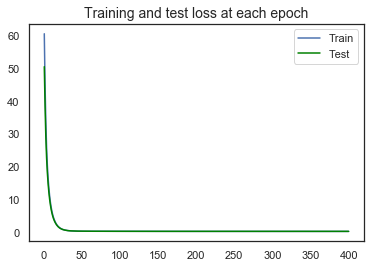

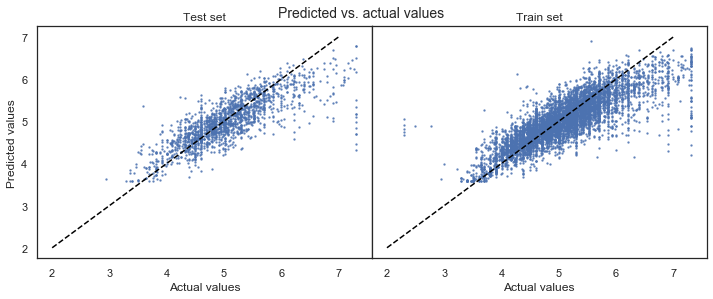

In [104]:
# Evaluating the model
model_evaluation(nn3)

Regularization and more layers have increased the r2 value compared to model 2. 

### Model 4: neural network with SGD optimizer

In [105]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               10496     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513       
Total params: 241,409
Trainable params: 241,409
Non-trainable params: 0
_________________________________________________________________
None


In [106]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=250,
                  batch_size=256,
                  validation_split = 0.1)

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

Train on 6171 samples, validate on 686 samples
Epoch 1/250
6171/6171 [==============================] - 0s 77us/step - loss: 63.1081 - mean_squared_error: 2.4072 - val_loss: 60.4966 - val_mean_squared_error: 0.5894
Epoch 2/250
6171/6171 [==============================] - 0s 52us/step - loss: 59.7017 - mean_squared_error: 0.4773 - val_loss: 58.8629 - val_mean_squared_error: 0.4276
Epoch 3/250
6171/6171 [==============================] - 0s 52us/step - loss: 58.1322 - mean_squared_error: 0.3687 - val_loss: 57.3530 - val_mean_squared_error: 0.3680
Epoch 4/250
6171/6171 [==============================] - 0s 53us/step - loss: 56.6514 - mean_squared_error: 0.3287 - val_loss: 55.8796 - val_mean_squared_error: 0.3239
Epoch 5/250
6171/6171 [==============================] - 0s 58us/step - loss: 55.1991 - mean_squared_error: 0.2980 - val_loss: 54.7870 - val_mean_squared_error: 0.6476
Epoch 6/250
6171/6171 [==============================] - 0s 52us/step - loss: 53.8018 - mean_squared_error: 0.302

6171/6171 [==============================] - 0s 46us/step - loss: 11.3083 - mean_squared_error: 0.1730 - val_loss: 11.0206 - val_mean_squared_error: 0.1919
Epoch 50/250
6171/6171 [==============================] - 0s 50us/step - loss: 10.7440 - mean_squared_error: 0.1746 - val_loss: 10.4686 - val_mean_squared_error: 0.1923
Epoch 51/250
6171/6171 [==============================] - 0s 47us/step - loss: 10.1962 - mean_squared_error: 0.1739 - val_loss: 9.9307 - val_mean_squared_error: 0.1925
Epoch 52/250
6171/6171 [==============================] - 0s 46us/step - loss: 9.6687 - mean_squared_error: 0.1743 - val_loss: 9.4119 - val_mean_squared_error: 0.1934
Epoch 53/250
6171/6171 [==============================] - 0s 45us/step - loss: 9.1617 - mean_squared_error: 0.1762 - val_loss: 8.9144 - val_mean_squared_error: 0.1959
Epoch 54/250
6171/6171 [==============================] - 0s 47us/step - loss: 8.6708 - mean_squared_error: 0.1754 - val_loss: 8.4387 - val_mean_squared_error: 0.2009
Epoch 

6171/6171 [==============================] - 0s 50us/step - loss: 0.8658 - mean_squared_error: 0.1852 - val_loss: 0.8667 - val_mean_squared_error: 0.2012
Epoch 99/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.8372 - mean_squared_error: 0.1848 - val_loss: 0.8602 - val_mean_squared_error: 0.2197
Epoch 100/250
6171/6171 [==============================] - 0s 51us/step - loss: 0.8125 - mean_squared_error: 0.1859 - val_loss: 0.8185 - val_mean_squared_error: 0.2060
Epoch 101/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.7868 - mean_squared_error: 0.1851 - val_loss: 0.7895 - val_mean_squared_error: 0.2003
Epoch 102/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.7627 - mean_squared_error: 0.1844 - val_loss: 0.7671 - val_mean_squared_error: 0.1990
Epoch 103/250
6171/6171 [==============================] - 0s 49us/step - loss: 0.7414 - mean_squared_error: 0.1849 - val_loss: 0.7457 - val_mean_squared_error: 0.1995
Epoch 1

Epoch 147/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3402 - mean_squared_error: 0.1802 - val_loss: 0.3572 - val_mean_squared_error: 0.1956
Epoch 148/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3391 - mean_squared_error: 0.1803 - val_loss: 0.3463 - val_mean_squared_error: 0.1881
Epoch 149/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3365 - mean_squared_error: 0.1795 - val_loss: 0.3468 - val_mean_squared_error: 0.1895
Epoch 150/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.3356 - mean_squared_error: 0.1801 - val_loss: 0.3436 - val_mean_squared_error: 0.1886
Epoch 151/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3341 - mean_squared_error: 0.1802 - val_loss: 0.3425 - val_mean_squared_error: 0.1888
Epoch 152/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3319 - mean_squared_error: 0.1795 - val_loss: 0.3428 - val_mean_squared_error:

Epoch 196/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.2930 - mean_squared_error: 0.1762 - val_loss: 0.3102 - val_mean_squared_error: 0.1922
Epoch 197/250
6171/6171 [==============================] - 0s 44us/step - loss: 0.2930 - mean_squared_error: 0.1766 - val_loss: 0.3028 - val_mean_squared_error: 0.1869
Epoch 198/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.2921 - mean_squared_error: 0.1763 - val_loss: 0.3140 - val_mean_squared_error: 0.1959
Epoch 199/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.2923 - mean_squared_error: 0.1766 - val_loss: 0.3061 - val_mean_squared_error: 0.1892
Epoch 200/250
6171/6171 [==============================] - 0s 55us/step - loss: 0.2911 - mean_squared_error: 0.1760 - val_loss: 0.3001 - val_mean_squared_error: 0.1845
Epoch 201/250
6171/6171 [==============================] - 0s 49us/step - loss: 0.2911 - mean_squared_error: 0.1765 - val_loss: 0.3028 - val_mean_squared_error:

Epoch 245/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.2734 - mean_squared_error: 0.1717 - val_loss: 0.2862 - val_mean_squared_error: 0.1844
Epoch 246/250
6171/6171 [==============================] - 0s 44us/step - loss: 0.2733 - mean_squared_error: 0.1718 - val_loss: 0.3123 - val_mean_squared_error: 0.2095
Epoch 247/250
6171/6171 [==============================] - 0s 44us/step - loss: 0.2740 - mean_squared_error: 0.1728 - val_loss: 0.2855 - val_mean_squared_error: 0.1844
Epoch 248/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.2722 - mean_squared_error: 0.1713 - val_loss: 0.2877 - val_mean_squared_error: 0.1866
Epoch 249/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.2724 - mean_squared_error: 0.1717 - val_loss: 0.2852 - val_mean_squared_error: 0.1841
Epoch 250/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.2722 - mean_squared_error: 0.1716 - val_loss: 0.2853 - val_mean_squared_error:

Training MSE: 0.1723
Validation MSE: 0.1894

Training r2: 0.6621
Validation r2: 0.6287


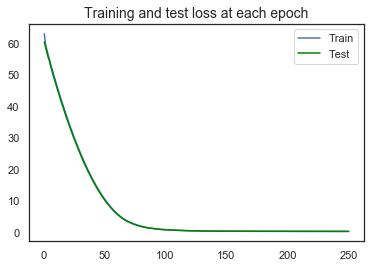

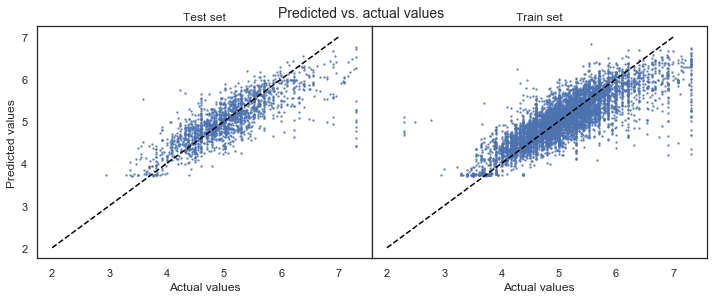

In [107]:
model_evaluation(nn4)

### Model 5: removing excess review rating features

So far, a number of hyperparameters have been tuned in order to increase the performance of the NN. Adding extra layers can often increase the performance of a NN, at the cost of increasing computational requirements. 

This model will drop review columns other than the overall review rating, and use the same NN structure as Model 3, in order to see whether this produces a better model.

Columns will be dropped from the existing X_train and X_test split, for consistency.

In [108]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

In [109]:
# Building the model
nn5 = models.Sequential()
nn5.add(layers.Dense(128, input_shape=(X_train_short.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn5.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn5.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn5.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               8192      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 239,105
Trainable params: 239,105
Non-trainable params: 0
_________________________________________________________________
None


In [110]:
# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train_short,
                  y_train,
                  epochs=250,
                  batch_size=256,
                  validation_split=0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

Train on 6171 samples, validate on 686 samples
Epoch 1/250
6171/6171 [==============================] - 1s 91us/step - loss: 60.9712 - mean_squared_error: 5.2324 - val_loss: 50.6261 - val_mean_squared_error: 1.4556
Epoch 2/250
6171/6171 [==============================] - 0s 53us/step - loss: 44.1213 - mean_squared_error: 0.6301 - val_loss: 37.6765 - val_mean_squared_error: 0.4346
Epoch 3/250
6171/6171 [==============================] - 0s 48us/step - loss: 32.9550 - mean_squared_error: 0.3217 - val_loss: 28.1471 - val_mean_squared_error: 0.3317
Epoch 4/250
6171/6171 [==============================] - 0s 51us/step - loss: 24.9002 - mean_squared_error: 0.2654 - val_loss: 21.7309 - val_mean_squared_error: 0.3013
Epoch 5/250
6171/6171 [==============================] - 0s 53us/step - loss: 19.5251 - mean_squared_error: 0.2433 - val_loss: 17.3247 - val_mean_squared_error: 0.2741
Epoch 6/250
6171/6171 [==============================] - 0s 51us/step - loss: 15.7122 - mean_squared_error: 0.226

6171/6171 [==============================] - 0s 48us/step - loss: 0.4334 - mean_squared_error: 0.1853 - val_loss: 0.4507 - val_mean_squared_error: 0.2058
Epoch 50/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.4308 - mean_squared_error: 0.1854 - val_loss: 0.4468 - val_mean_squared_error: 0.2030
Epoch 51/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.4277 - mean_squared_error: 0.1857 - val_loss: 0.4439 - val_mean_squared_error: 0.2036
Epoch 52/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.4232 - mean_squared_error: 0.1848 - val_loss: 0.4375 - val_mean_squared_error: 0.2010
Epoch 53/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.4201 - mean_squared_error: 0.1848 - val_loss: 0.4380 - val_mean_squared_error: 0.2054
Epoch 54/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.4179 - mean_squared_error: 0.1850 - val_loss: 0.4320 - val_mean_squared_error: 0.2009
Epoch 55/25

6171/6171 [==============================] - 0s 59us/step - loss: 0.3804 - mean_squared_error: 0.1807 - val_loss: 0.4029 - val_mean_squared_error: 0.2035
Epoch 99/250
6171/6171 [==============================] - 0s 53us/step - loss: 0.3827 - mean_squared_error: 0.1823 - val_loss: 0.3994 - val_mean_squared_error: 0.1978
Epoch 100/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3810 - mean_squared_error: 0.1813 - val_loss: 0.3937 - val_mean_squared_error: 0.1958
Epoch 101/250
6171/6171 [==============================] - 0s 48us/step - loss: 0.3780 - mean_squared_error: 0.1801 - val_loss: 0.3970 - val_mean_squared_error: 0.1984
Epoch 102/250
6171/6171 [==============================] - 0s 48us/step - loss: 0.3799 - mean_squared_error: 0.1813 - val_loss: 0.3966 - val_mean_squared_error: 0.1997
Epoch 103/250
6171/6171 [==============================] - 0s 48us/step - loss: 0.3800 - mean_squared_error: 0.1817 - val_loss: 0.3940 - val_mean_squared_error: 0.1965
Epoch 1

Epoch 147/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3738 - mean_squared_error: 0.1820 - val_loss: 0.3853 - val_mean_squared_error: 0.1936
Epoch 148/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3693 - mean_squared_error: 0.1789 - val_loss: 0.3824 - val_mean_squared_error: 0.1937
Epoch 149/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3682 - mean_squared_error: 0.1788 - val_loss: 0.3804 - val_mean_squared_error: 0.1917
Epoch 150/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3687 - mean_squared_error: 0.1792 - val_loss: 0.3832 - val_mean_squared_error: 0.1939
Epoch 151/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3668 - mean_squared_error: 0.1777 - val_loss: 0.3812 - val_mean_squared_error: 0.1929
Epoch 152/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3666 - mean_squared_error: 0.1782 - val_loss: 0.3811 - val_mean_squared_error:

Epoch 196/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3655 - mean_squared_error: 0.1782 - val_loss: 0.3795 - val_mean_squared_error: 0.1919
Epoch 197/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3641 - mean_squared_error: 0.1768 - val_loss: 0.3805 - val_mean_squared_error: 0.1951
Epoch 198/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3642 - mean_squared_error: 0.1780 - val_loss: 0.3789 - val_mean_squared_error: 0.1934
Epoch 199/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3633 - mean_squared_error: 0.1777 - val_loss: 0.3773 - val_mean_squared_error: 0.1920
Epoch 200/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3636 - mean_squared_error: 0.1781 - val_loss: 0.3806 - val_mean_squared_error: 0.1950
Epoch 201/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.3657 - mean_squared_error: 0.1786 - val_loss: 0.3777 - val_mean_squared_error:

Epoch 245/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.3638 - mean_squared_error: 0.1786 - val_loss: 0.3757 - val_mean_squared_error: 0.1916
Epoch 246/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3607 - mean_squared_error: 0.1768 - val_loss: 0.3760 - val_mean_squared_error: 0.1930
Epoch 247/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3593 - mean_squared_error: 0.1762 - val_loss: 0.3746 - val_mean_squared_error: 0.1917
Epoch 248/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3605 - mean_squared_error: 0.1772 - val_loss: 0.3767 - val_mean_squared_error: 0.1934
Epoch 249/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.3597 - mean_squared_error: 0.1764 - val_loss: 0.3739 - val_mean_squared_error: 0.1915
Epoch 250/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.3602 - mean_squared_error: 0.1769 - val_loss: 0.3811 - val_mean_squared_error:

Training MSE: 0.1789
Validation MSE: 0.1965

Training r2: 0.6492
Validation r2: 0.6148


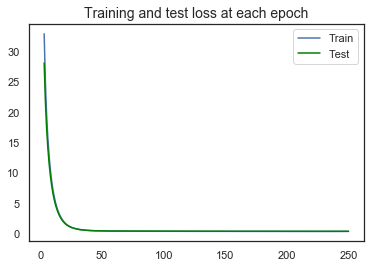

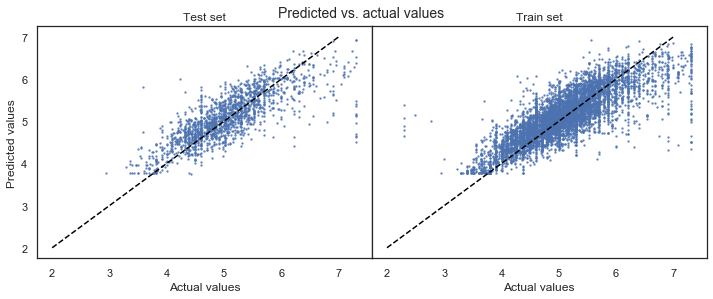

In [111]:
model_evaluation(nn5, skip_epochs=2, X_train=X_train_short, X_test=X_test_short)

### Model 6: four-layer neural network with a min-max scaler

In [112]:
# Dropping review columns from the original dataframe (after log transformation)
df_minmax = transformed_df.drop(review_to_drop, axis=1)

# Separating X and y
X_minmax = df_minmax.drop('price', axis=1)
y_minmax = df_minmax.price

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X_minmax = pd.DataFrame(scaler.fit_transform(X_minmax), columns=list(X_minmax.columns))

# Splitting into train and test sets
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax, y_minmax, test_size=0.2, random_state=123)

In [113]:
# Building the model
nn6 = models.Sequential()
nn6.add(layers.Dense(128, input_shape=(X_train_minmax.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn6.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn6.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn6.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn6.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn6.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               8192      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 513       
Total params: 239,105
Trainable params: 239,105
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
# Training the model
nn6_start = time.time()

nn6_history = nn6.fit(X_train_minmax,
                  y_train_minmax,
                  epochs=250,
                  batch_size=256,
                  validation_split = 0.1)

nn6_end = time.time()

print(f"Time taken to run: {round((nn6_end - nn6_start)/60,1)} minutes")

Train on 6171 samples, validate on 686 samples
Epoch 1/250
6171/6171 [==============================] - 1s 93us/step - loss: 58.7081 - mean_squared_error: 5.1734 - val_loss: 46.4205 - val_mean_squared_error: 1.1481
Epoch 2/250
6171/6171 [==============================] - 0s 51us/step - loss: 39.3524 - mean_squared_error: 0.6329 - val_loss: 32.2709 - val_mean_squared_error: 0.5216
Epoch 3/250
6171/6171 [==============================] - 0s 50us/step - loss: 27.3040 - mean_squared_error: 0.3873 - val_loss: 22.4346 - val_mean_squared_error: 0.3754
Epoch 4/250
6171/6171 [==============================] - 0s 51us/step - loss: 19.4920 - mean_squared_error: 0.3375 - val_loss: 16.7416 - val_mean_squared_error: 0.3486
Epoch 5/250
6171/6171 [==============================] - 0s 52us/step - loss: 15.0418 - mean_squared_error: 0.3128 - val_loss: 13.3941 - val_mean_squared_error: 0.3265
Epoch 6/250
6171/6171 [==============================] - 0s 51us/step - loss: 12.2552 - mean_squared_error: 0.296

Epoch 50/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.5660 - mean_squared_error: 0.2212 - val_loss: 0.5784 - val_mean_squared_error: 0.2401
Epoch 51/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.5570 - mean_squared_error: 0.2217 - val_loss: 0.5583 - val_mean_squared_error: 0.2292
Epoch 52/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.5464 - mean_squared_error: 0.2205 - val_loss: 0.5504 - val_mean_squared_error: 0.2290
Epoch 53/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.5382 - mean_squared_error: 0.2197 - val_loss: 0.5477 - val_mean_squared_error: 0.2341
Epoch 54/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.5332 - mean_squared_error: 0.2209 - val_loss: 0.5425 - val_mean_squared_error: 0.2343
Epoch 55/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.5252 - mean_squared_error: 0.2199 - val_loss: 0.5308 - val_mean_squared_error: 0.226

6171/6171 [==============================] - 0s 61us/step - loss: 0.4269 - mean_squared_error: 0.2122 - val_loss: 0.4377 - val_mean_squared_error: 0.2223
Epoch 100/250
6171/6171 [==============================] - 0s 57us/step - loss: 0.4287 - mean_squared_error: 0.2134 - val_loss: 0.4310 - val_mean_squared_error: 0.2166
Epoch 101/250
6171/6171 [==============================] - 0s 56us/step - loss: 0.4254 - mean_squared_error: 0.2115 - val_loss: 0.4296 - val_mean_squared_error: 0.2163
Epoch 102/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.4248 - mean_squared_error: 0.2119 - val_loss: 0.4295 - val_mean_squared_error: 0.2157
Epoch 103/250
6171/6171 [==============================] - 0s 45us/step - loss: 0.4297 - mean_squared_error: 0.2139 - val_loss: 0.4310 - val_mean_squared_error: 0.2164
Epoch 104/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.4246 - mean_squared_error: 0.2118 - val_loss: 0.4283 - val_mean_squared_error: 0.2167
Epoch 

Epoch 148/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.4179 - mean_squared_error: 0.2099 - val_loss: 0.4210 - val_mean_squared_error: 0.2141
Epoch 149/250
6171/6171 [==============================] - 0s 48us/step - loss: 0.4161 - mean_squared_error: 0.2092 - val_loss: 0.4209 - val_mean_squared_error: 0.2140
Epoch 150/250
6171/6171 [==============================] - 0s 47us/step - loss: 0.4163 - mean_squared_error: 0.2094 - val_loss: 0.4206 - val_mean_squared_error: 0.2137
Epoch 151/250
6171/6171 [==============================] - 0s 63us/step - loss: 0.4153 - mean_squared_error: 0.2086 - val_loss: 0.4217 - val_mean_squared_error: 0.2146
Epoch 152/250
6171/6171 [==============================] - 0s 55us/step - loss: 0.4156 - mean_squared_error: 0.2090 - val_loss: 0.4198 - val_mean_squared_error: 0.2138
Epoch 153/250
6171/6171 [==============================] - 0s 51us/step - loss: 0.4150 - mean_squared_error: 0.2089 - val_loss: 0.4187 - val_mean_squared_error:

Epoch 197/250
6171/6171 [==============================] - 0s 55us/step - loss: 0.4086 - mean_squared_error: 0.2085 - val_loss: 0.4141 - val_mean_squared_error: 0.2127
Epoch 198/250
6171/6171 [==============================] - 0s 60us/step - loss: 0.4092 - mean_squared_error: 0.2085 - val_loss: 0.4120 - val_mean_squared_error: 0.2116
Epoch 199/250
6171/6171 [==============================] - 0s 56us/step - loss: 0.4079 - mean_squared_error: 0.2081 - val_loss: 0.4123 - val_mean_squared_error: 0.2120
Epoch 200/250
6171/6171 [==============================] - 0s 57us/step - loss: 0.4080 - mean_squared_error: 0.2077 - val_loss: 0.4109 - val_mean_squared_error: 0.2113
Epoch 201/250
6171/6171 [==============================] - 0s 58us/step - loss: 0.4067 - mean_squared_error: 0.2071 - val_loss: 0.4130 - val_mean_squared_error: 0.2144
Epoch 202/250
6171/6171 [==============================] - 0s 58us/step - loss: 0.4075 - mean_squared_error: 0.2079 - val_loss: 0.4154 - val_mean_squared_error:

Epoch 246/250
6171/6171 [==============================] - 0s 49us/step - loss: 0.4052 - mean_squared_error: 0.2092 - val_loss: 0.4099 - val_mean_squared_error: 0.2136
Epoch 247/250
6171/6171 [==============================] - 0s 48us/step - loss: 0.4015 - mean_squared_error: 0.2065 - val_loss: 0.4072 - val_mean_squared_error: 0.2132
Epoch 248/250
6171/6171 [==============================] - 0s 48us/step - loss: 0.4003 - mean_squared_error: 0.2063 - val_loss: 0.4051 - val_mean_squared_error: 0.2114
Epoch 249/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.4003 - mean_squared_error: 0.2065 - val_loss: 0.4067 - val_mean_squared_error: 0.2132
Epoch 250/250
6171/6171 [==============================] - 0s 46us/step - loss: 0.4014 - mean_squared_error: 0.2072 - val_loss: 0.4073 - val_mean_squared_error: 0.2133
Time taken to run: 1.3 minutes


Training MSE: 0.2075
Validation MSE: 0.226

Training r2: 0.5931
Validation r2: 0.557


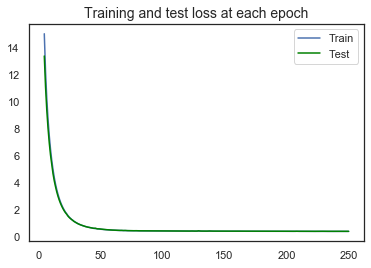

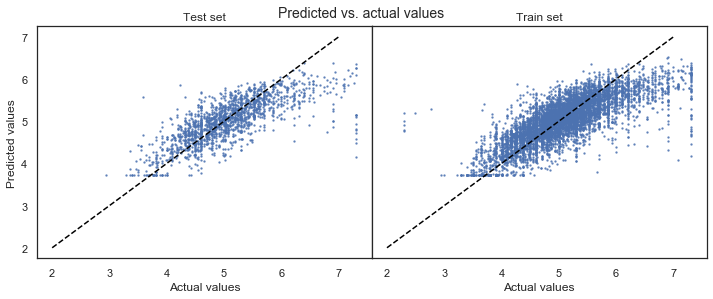

In [115]:
model_evaluation(nn6, skip_epochs=4, X_train=X_train_minmax, X_test=X_test_minmax, y_train=y_train_minmax, y_test=y_test_minmax)

### Performance Overview through models 1-6

In [116]:
print('Model 1: XGBoost')
print("Training MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))
print('\n')
print('Model 2: 3-Layer Neural Network')
score_eval(nn2)
print('\n')
print('Model 3: 4-Layer Neural Network with L1 Regularization')
score_eval(nn3)
print('\n')
print('Model 4: Neural Network with SGD Optimizer')
score_eval(nn4)
print('\n')
print('Model 5: removing excess review rating features')
score_eval(nn5, skip_epochs=2, X_train=X_train_short, X_test=X_test_short)
print('\n')
print('Model 6: 4-Layer Neural Network with a min-max Scale')
score_eval(nn6, skip_epochs=4, X_train=X_train_minmax, X_test=X_test_minmax, 
           y_train=y_train_minmax, y_test=y_test_minmax)

Model 1: XGBoost
Training MSE: 0.1382
Validation MSE: 0.1668

Training r2: 0.7289
Validation r2: 0.6731


Model 2: 3-Layer Neural Network
Training MSE: 0.0263
Validation MSE: 0.2084

Training r2: 0.9484
Validation r2: 0.5915


Model 3: 4-Layer Neural Network with L1 Regularization
Training MSE: 0.1683
Validation MSE: 0.1886

Training r2: 0.6699
Validation r2: 0.6303


Model 4: Neural Network with SGD Optimizer
Training MSE: 0.1723
Validation MSE: 0.1894

Training r2: 0.6621
Validation r2: 0.6287


Model 5: removing excess review rating features
Training MSE: 0.1789
Validation MSE: 0.1965

Training r2: 0.6492
Validation r2: 0.6148


Model 6: 4-Layer Neural Network with a min-max Scale
Training MSE: 0.2075
Validation MSE: 0.226

Training r2: 0.5931
Validation r2: 0.557


# Conclusion

While deep learning isn't necessary for prediction, a machine learning model performs just as well. However, even in the best performing model **(Model 1 - XGBoost model).**, the model was only able to explain 67% of the variation in price. The remaining 33% could include features that were not present in the data. It is likely that a significant proportion of this unexplained variance is due to variations in the listing photos; the photos of listing on AirBnB are very important in encouraging guests to book, and can also be expected to have a significant impact on price. Better p"hotos equal higher prices (professional-quality photos, better furnishings, updated/modern amenities, etc.).

Other models, like **Model 3 with L1 regularization** and **Model 4 with SGD Optimizers**, performed closely with the XGboost model. Other regularization methods may prove to be useful or beneficial. 

**Model 5 with removed review ratings** also performed closely with **Model 1** and **Model 4**, and could potentially show that hyperparameter tuning can further improve the accurate predictions of price on an AirBnB listing. 

### Potential Shortcomings and Ways to Improve Future Models

- Find a method to incorporate image quality into the model by using the output of a convolutional neural network to assess image quality as an input into the pricing model
- Use better quality/more accurate data which includes the actual average prices paid per night. More data in general could be useful.
- Include a wider geographic area, like all of California, or the west region of the US.
- Support the model with natural language processing (NLP) of listing descriptions and/or reviews, e.g. for sentiment analysis or looking for keywords